# JSLDS Jacobian Switching Linear Dynamical System 

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Imports

In [ ]:
# Numpy, JAX, Matplotlib and h5py should all be correctly installed and on the 
# python path.
import datetime
import functools
import h5py
import jax
from jax.test_libraries import optimizers
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np             # original CPU-backed NumPy
import os
import scipy.spatial
from sklearn.decomposition import PCA
import sys
import time

# Occasionally useful for numerical debugging.
# from jax.config import config
# config.update("jax_debug_nans", True)

In [ ]:
jax.devices()

[PjRtTpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0),
 PjRtTpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=1),
 PjRtTpuDevice(id=2, host_id=0, coords=(1,0,0), core_on_chip=0),
 PjRtTpuDevice(id=3, host_id=0, coords=(1,0,0), core_on_chip=1),
 PjRtTpuDevice(id=4, host_id=0, coords=(0,1,0), core_on_chip=0),
 PjRtTpuDevice(id=5, host_id=0, coords=(0,1,0), core_on_chip=1),
 PjRtTpuDevice(id=6, host_id=0, coords=(1,1,0), core_on_chip=0),
 PjRtTpuDevice(id=7, host_id=0, coords=(1,1,0), core_on_chip=1)]

# RNN and Training Code


In [ ]:
"""JSLDS RNN functions for init, definition and running."""

MAX_SEED_INT = 10000000


def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:
    2-tuple (new key for further generators, key generator)
  """
  keys = jax.random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])


def get_warmup_fun(warmup_start, warmup_end, val_min, val_max):
  """Warmup function avoid a pathological conditions early in training.

  Args:
    warmup_start: index to start warmup
    warmup_end: index to stop warmup
    val_min: minimal value for warmup at beginning
    val_max: maximal value for wamrup at end

  Returns:
    a function which yields the warmup value
  """

  def warmup(batch_idx):
    progress_frac = ((batch_idx - warmup_start) / (warmup_end - warmup_start))
    warmup = jnp.where(batch_idx < warmup_start,
                       val_min,
                       (val_max - val_min) * progress_frac + val_min)
    return jnp.where(batch_idx > warmup_end, val_max, warmup)
  return warmup


def affine_params(key, **affine_hps):
  """Params for y = W x + b.

  Args:
    key: random.PRNGKey for random bits
    **affine_hps: dict of hps such as 'u' for input size, 'o' for output size,
      'ifactor' for scaling factor

  Returns:
    a dictionary of parameters
  """

  key, skeys = keygen(key, 1)
  u = affine_hps['u']
  o = affine_hps['o']
  i_factor = affine_hps['i_factor']
  i_factor = i_factor / jnp.sqrt(u)
  return {'W': jax.random.normal(next(skeys), (o, u)) * i_factor,
          'b': jnp.zeros((o,))}


def mlp_params(key, nlayers, n):  # pylint: disable=unused-argument
  """Build a very specific multilayer perceptron for picking fixed points.

  Args:
    key: random.PRNGKey for randomness
    nlayers: number of layers in the MLP.
    n: MLP dimension

  Returns:
    List of dictionaries, where list index is the layer (indexed by integer)
      and each dict is the params of the layer, i.e. weights and bias.
  """
  params = [None] * nlayers
  for l in range(nlayers):
    # Below we build against identity, so zeros appropriate here.
    params[l] = {'W': jnp.zeros([n, n]), 'b': jnp.zeros(n)}
  return params


def gru_params(key, **rnn_hps):
  """Generate GRU parameters.

  Args:
    key: random.PRNGKey for random bits
    **rnn_hps: key-value pairs in dict as
       n, hidden state size
       u, input size
       i_factor, scaling factor for input weights
       h_factor, scaling factor for hidden -> hidden weights
       h_scale, scale on h0 initial condition

  Returns:
    a dictionary of parameters
  """
  key, skeys = keygen(key, 5)
  u = rnn_hps['u']
  n = rnn_hps['n']

  ifactor = rnn_hps['i_factor'] / jnp.sqrt(u)
  hfactor = rnn_hps['h_factor'] / jnp.sqrt(n)
  hscale = rnn_hps['h_scale']

  wRUH = jax.random.normal(next(skeys), (n + n, n)) * hfactor
  wRUX = jax.random.normal(next(skeys), (n + n, u)) * ifactor
  wRUHX = jnp.concatenate([wRUH, wRUX], axis=1)

  wCH = jax.random.normal(next(skeys), (n, n)) * hfactor
  wCX = jax.random.normal(next(skeys), (n, u)) * ifactor
  wCHX = jnp.concatenate([wCH, wCX], axis=1)

  return {'h0': jax.random.normal(next(skeys), (n,)) * hscale,
          'wRUHX': wRUHX,
          'wCHX': wCHX,
          'bRU': jnp.zeros((n+n,)),
          'bC': jnp.zeros((n,))}


def vrnn_params(key, **rnn_hps):
  """Generate random Vanilla RNN parameters.

  Args:
    key: random.PRNGKey for randomness
    **rnn_hps: dictionary of hps for VRNN, re size and scaling

  Returns:
    a dict of params appropriate for a 1-layer VRNN
  """

  u = rnn_hps['u']
  n = rnn_hps['n']
  key, skeys = keygen(key, 4)
  hscale = 0.1
  ifactor = 1.0 / jnp.sqrt(u)
  # pfactor = 1.0 / jnp.sqrt(n)

  if rnn_hps['recurrent_is_identity']:
    wR = rnn_hps['h_factor'] * jnp.eye(n)
  else:
    g = rnn_hps['h_factor'] / jnp.sqrt(n)
    wR = jax.random.normal(next(skeys), (n, n)) *  g

  return {'h0': jax.random.normal(next(skeys), (n,)) * hscale,
          'wI': jax.random.normal(next(skeys), (n, u)) * ifactor,
          'wR': wR,
          'bR': jnp.zeros([n])}


def jslds_rnn_params(key, **rnn_hps):
  """Generate parameters for Jacobian Switching Lindear Dynamical Systems model.

  Args:
    key: random.PRNGKey for randomness
    **rnn_hps: (nested) dictionary of hyperparameters relevant for JSLDS model.

  Returns:
    A (nested) dictionary of all params relevant for JSLDS RNN.
  """
  key, skeys = keygen(key, 3)
  rnn_params_fun = rnn_hps['rnn']['params_fun']
  return {'mlp': mlp_params(next(skeys), **rnn_hps['mlp']),
          'rnn': rnn_params_fun(next(skeys), **rnn_hps['rnn']),
          'out': affine_params(next(skeys), **rnn_hps['out'])}


def jslds_gru_params(key, nlayers, u, n, o,
                     ifactor=1.0, hfactor=1.0, hscale=0.0):
  key, skeys = keygen(key, 2)

  gru_hps = {'u': u, 'n': n, 'o': o, 'ifactor': ifactor, 'hfactor': hfactor,
             'hscale': hscale}
  affine_hps = {'u': n, 'o': o, 'ifactor': 1.0}
  return {'mlp': mlp_params(next(skeys), nlayers, n),
          'rnn': gru_params(next(skeys), **gru_hps),
          'out': affine_params(next(skeys), **affine_hps)}


def sigmoid(x):
  return 0.5 * (jnp.tanh(x / 2.) + 1)


def affine(params, x):
  """Implement y = W x + b."""
  return jnp.dot(params['W'], x) + params['b']


# Affine expects n_W_m m_x_1, but passing in t_x_m (has txm dims)
# So map over first dimension to handle t_x_m.
# I.e. if affine yields n_y_1 = dot(n_W_m, m_x_1), then
# batch_affine yields t_y_n.
# And so the vectorization pattern goes for all batch_* functions.
batch_affine = jax.vmap(affine, in_axes=(None, 0))


def mlp_tanh(params, x):
  """Multilayer perceptrain with tanh nonlinearity.

  Args:
    params: dict of params for MLP
    x: input

  Returns:
    hidden state after applying the MLP
  """
  h = x
  for layer in params:
    h = jnp.tanh(h + jnp.dot(layer['W'], h) + layer['b'])
  return h


# Sussillo: The relu version just seems to make instability more likely.
def mlp_relu(params, x, b=0.01):
  """Multilayer perceptron with relu nonlinearity.

  Args:
    params: dict of params for MLP
    x: input
    b: static bias for each layer

  Returns:
    hidden state after applying the MLP
  """
  h = x
  for layer in params:
    a = h + jnp.dot(layer['W'], h) + layer['b'] + b
    h = jnp.where(a > 0.0, a, 0.0)
  return h


mlp = mlp_tanh
batch_mlp = jax.vmap(mlp, in_axes=(None, 0))


def vrnn_tanh(params, h, x):
  """Run the Vanilla RNN (tanh) one step.

  Args:
    params: dict of params for VRNN
    h: hidden state of the RNN
    x: input for the RNN

  Returns:
    the hidden state of the RNN after running one step forward in time
  """
  a = jnp.dot(params['wI'], x) + params['bR'] + jnp.dot(params['wR'], h)
  return jnp.tanh(a)


def vrnn_relu(params, h, x):
  """Run the Vanilla RNN (relu) one step.

  Args:
    params: dict of params for VRNN
    h: hidden state of the RNN
    x: input for the RNN

  Returns:
    the hidden state of the RNN after running one step forward in time
  """
  a = jnp.dot(params['wI'], x) + params['bR'] + jnp.dot(params['wR'], h)
  return jnp.where(a > 0.0, a, 0.0)


def gru(params, h, x, bfg=0.0):
  """Implement the GRU equations.

  Arguments:
    params: dictionary of GRU parameters
    h: np array of  hidden state
    x: np array of input
    bfg: bias on forget gate (useful for learning if > 0.0)

  Returns:
    np array of hidden state after GRU update
  """

  hx = jnp.concatenate([h, x], axis=0)
  ru = jnp.dot(params['wRUHX'], hx) + params['bRU']
  r, u = jnp.split(ru, 2, axis=0)
  u = u + bfg
  u = sigmoid(u)
  r = sigmoid(r)
  rhx = jnp.concatenate([r * h, x])
  c = jnp.tanh(jnp.dot(params['wCHX'], rhx) + params['bC'])
  return u * h + (1.0 - u) * c


def taylor(f, order):
  """Compute nth order Taylor series approximation of f.

  Args:
    f: the function to compute the Taylor series expansion on, with signature
        f:: h, x -> h
    order: the order of the expansion (int)

  Returns:
    order-order Taylor series approximation as a function with signature
      T[f]: h, x -> h
  """

  def jvp_first(f, primals, tangent):
    """Jacobian-vector product of first argument element."""
    x, xs = primals[0], primals[1:]
    return jax.jvp(lambda x: f(x, *xs), (x,), (tangent,))

  def improve_approx(g, k):
    """Improve taylor series approximation step-by-step."""
    return lambda x, v: jvp_first(g, (x, v), v)[1] + f(x) / math.factorial(k)

  approx = lambda x, v: f(x) / math.factorial(order)
  for n in range(order):
    approx = improve_approx(approx, order - n - 1)
  return approx


def taylor_approx_rnn(rnn, params, h_star, x_star, h_approx_tm1, x_t, order):
  xdim = x_t.shape[0]
  hx_star = jnp.concatenate([h_star, x_star], axis=0)
  hx = jnp.concatenate([h_approx_tm1, x_t], axis=0)

  Fhx = lambda hx: rnn(params, hx[:-xdim], hx[-xdim:])
  return taylor(Fhx, order)(hx_star, hx - hx_star)


def staylor_rnn(rnn, params, order, h_tm1, h_approx_tm1, x_t):
  """Run the switching taylor rnn."""
  x_star = jnp.zeros_like(x_t)
  h_star = mlp(params['mlp'], h_approx_tm1)
  F_star = rnn(params['rnn'], h_star, x_star)

  # Taylor series expansion includes 0 order, so we subtract it off,
  # using the learned MLP point instead. This makes sense because we
  # expanded around (h*,x*), and if the MLP produces a fixed point (thanks
  # to the fixed point regularization pressure), it is equal to F(h*,x*).
  h_staylor_t = taylor_approx_rnn(rnn, params['rnn'], h_star, x_star,
                                  h_approx_tm1, x_t, order)
  h_approx_t = h_staylor_t - F_star + h_star
  o_approx_t = affine(params['out'], h_approx_t)

  h_t = rnn(params['rnn'], h_tm1, x_t)
  o_t = affine(params['out'], h_t)
  return h_star, F_star, h_t, h_approx_t, o_t, o_approx_t


def jslds_rnn(rnn, params, h_tm1, h_approx_tm1, x_t):
  return staylor_rnn(rnn, params, 1, h_tm1, h_approx_tm1, x_t)


def jslds_rnn_scan(rnn, params, state, x_t):
  """Run the JSLDS network 1 step adapting the inputs and outputs for scan."""
  h_tm1, h_approx_tm1 = state
  state_and_returns = jslds_rnn(rnn, params, h_tm1, h_approx_tm1, x_t)
  h_star, F_star, h_t, h_approx_t, o_t, o_approx_t = state_and_returns
  state = h_t, h_approx_t
  return state, state_and_returns


def jslds_rnn_run(params, x_t, rnn):
  """Run the RNN T steps, where T is shape[0] of input."""
  state0 = (params['rnn']['h0'], params['rnn']['h0'])
  # Convert signature to f: (state, x) -> (state, returns)
  this_jslds_rnn = functools.partial(jslds_rnn_scan, *(rnn, params))
  _, state_and_returns = jax.lax.scan(this_jslds_rnn, state0, x_t)
  return state_and_returns


def get_batch_rnn_run_fun(rnn):
  # Use partial because here because vmap doesn't handle arguments
  # that cannot be traced (I think).
  return jax.vmap(functools.partial(jslds_rnn_run, rnn=rnn), in_axes=(None, 0))


# TODO(sussillo) mask time in a non-hacky way.
def loss(params, inputs_bxtxu, targets_bxtxo, targets_mask_t, 
         out_nl_reg, out_jslds_reg, taylor_reg, fp_reg, l2_reg, rnn):
  """Compute the least squares loss of the output, plus L2 regularization."""
  batch_rnn_run = get_batch_rnn_run_fun(rnn)
  hstar_bxtxn, F0_bxtxn, h_bxtxn, h_approx_bxtxn, o_bxtxo, o_approx_bxtxo = \
      batch_rnn_run(params, inputs_bxtxu)

  l2_loss = l2_reg * optimizers.l2_norm(params)**2
  fp_loss = fp_reg * jnp.mean((F0_bxtxn - hstar_bxtxn)**2)

  fo_loss = taylor_reg * jnp.mean((h_bxtxn - h_approx_bxtxn)**2)

  o_bxsxo = o_bxtxo[:, targets_mask_t, :]
  o_approx_bxsxo = o_approx_bxtxo[:, targets_mask_t, :]
  targets_bxsxo = targets_bxtxo[:, targets_mask_t, :]

  lms_nl_loss = out_nl_reg * jnp.mean((o_bxsxo - targets_bxsxo)**2)
  lms_jslds_loss = out_jslds_reg * jnp.mean((o_approx_bxsxo - targets_bxsxo)**2)

  total_loss = lms_jslds_loss + lms_nl_loss + l2_loss + fp_loss + fo_loss
  return {'total': total_loss,
          'lms_jslds': lms_jslds_loss, 'lms_nl': lms_nl_loss,
          'l2': l2_loss, 'fixed_point': fp_loss, 'taylor': fo_loss}


loss_jit = jax.jit(loss, static_argnums=(9,))


def update_w_gc(i, opt_state, opt_update, get_params, x_bxt, f_bxt, f_mask_bxt,
                max_grad_norm, out_nl_reg, out_jslds_reg, taylor_reg,
                fp_reg, l2_reg, rnn):
  """Update the parameters w/ gradient clipped, gradient descent updates."""
  params = get_params(opt_state)

  def training_loss(params):
    return loss(params, x_bxt, f_bxt, f_mask_bxt, out_nl_reg, out_jslds_reg, 
                taylor_reg, fp_reg, l2_reg, rnn)['total']

  grads = jax.grad(training_loss)(params)

  clipped_grads = optimizers.clip_grads(grads, max_grad_norm)
  return opt_update(i, clipped_grads, opt_state)

update_w_gc_jit = jax.jit(update_w_gc, static_argnums=(2, 3, 13))


def run_trials(batch_run_fun, inputs_targets_h0s_fun, nbatches, batch_size):
  """Run a bunch of trials and save everything in a dictionary."""
  inputs = []
  h_stars = []
  F0_stars = []
  nl_hiddens = []
  nl_outputs = []
  hiddens = []
  outputs = []
  targets = []
  masks = []
  h0s = []
  for _ in range(nbatches):
    data_seeds = np.random.randint(0, MAX_SEED_INT, size=batch_size)
    keys = np.array([jax.random.PRNGKey(ds) for ds in data_seeds])
    input_b, target_b, masks_b, h0s_b = inputs_targets_h0s_fun(keys)
    if h0s_b is None:
      h_star_b, F0_star_b, h_b, h_approx_b, o_b, o_approx_b = \
          batch_run_fun(input_b)
    else:
      h_star_b, F0_star_b, h_b, h_approx_b, o_b, o_approx_b = \
          batch_run_fun(input_b, h0s_b)
      h0s.append(h0s_b)

    inputs.append(input_b)
    h_stars.append(h_star_b)
    F0_stars.append(F0_star_b)
    nl_hiddens.append(h_b)
    nl_outputs.append(o_b)
    hiddens.append(h_approx_b)
    outputs.append(o_approx_b)
    targets.append(target_b)
    masks.append(masks_b)

  trial_dict = {'inputs': np.vstack(inputs),
                'h_stars': np.vstack(h_stars),
                'F0_stars': np.vstack(F0_stars),
                'nl_hiddens': np.vstack(nl_hiddens),
                'nl_outputs': np.vstack(nl_outputs),
                'hiddens': np.vstack(hiddens),
                'outputs': np.vstack(outputs),
                'targets': np.vstack(targets), 
                'masks': np.vstack(masks)}

  if h0s_b is not None:
    trial_dict['h0s'] = np.vstack(h0s)
  else:
    trial_dict['h0s'] = None
  return trial_dict

# Fixed Point Finding Code

In [ ]:
def find_fixed_points(rnn_fun, candidates, hps, do_print=True):
  """Top-level routine to find fixed points, keeping only valid fixed points.
  This function will:
    Add noise to the fixed point candidates ('noise_var')
    Optimize to find the closest fixed points / slow points (many hps, 
      see optimize_fps)
    Exclude any fixed points whose fixed point loss is above threshold ('fp_tol')
    Exclude any non-unique fixed points according to a tolerance ('unique_tol')
    Exclude any far-away "outlier" fixed points ('outlier_tol')
    
  This top level function runs at the CPU level, while the actual JAX optimization 
  for finding fixed points is dispatched to device.
  Arguments: 
    rnn_fun: one-step update function as a function of hidden state
    candidates: ndarray with shape npoints x ndims
    hps: dict of hyper parameters for fp optimization, including
      tolerances related to keeping fixed points
  
  Returns: 
    4-tuple of (kept fixed points sorted with slowest points first, 
      fixed point losses, indicies of kept fixed points, details of 
      optimization)"""

  npoints, dim = candidates.shape
  
  noise_var = hps['noise_var']
  if do_print and noise_var > 0.0:
    print("Adding noise to fixed point candidates.")
    candidates += np.random.randn(npoints, dim) * np.sqrt(noise_var)
    
  if do_print:
    print("Optimizing to find fixed points.")
  fps, opt_details = optimize_fps(rnn_fun, candidates, hps, do_print)

  if do_print and hps['fp_tol'] < np.inf:  
    print("Excluding fixed points with squared speed above tolerance {:0.5f}.".format(hps['fp_tol']))
  fps, fp_kidxs = fixed_points_with_tolerance(rnn_fun, fps, hps['fp_tol'],
                                              do_print)
  if len(fp_kidxs) == 0:
    return np.zeros([0, dim]), np.zeros([0]), [], opt_details
  
  if do_print and hps['unique_tol'] > 0.0:  
    print("Excluding non-unique fixed points.")
  fps, unique_kidxs = keep_unique_fixed_points(fps, hps['unique_tol'],
                                               do_print)
  if len(unique_kidxs) == 0:
    return np.zeros([0, dim]), np.zeros([0]), [], opt_details
  
  if do_print and hps['outlier_tol'] < np.inf:  
    print("Excluding outliers.")
  fps, outlier_kidxs = exclude_outliers(fps, hps['outlier_tol'],
                                        'euclidean', do_print) # TODO(sussillo) Make hp?
  if len(outlier_kidxs) == 0:
    return np.zeros([0, dim]), np.zeros([0]), [], opt_details

  if do_print:
    print('Sorting fixed points slowest first.')    
  losses = np.array(get_fp_loss_fun(rnn_fun)(fps))# came back as jax.interpreters.xla.DeviceArray
  sort_idxs = np.argsort(losses) 
  fps = fps[sort_idxs]
  losses = losses[sort_idxs]
  try:
    keep_idxs = fp_kidxs[unique_kidxs[outlier_kidxs[sort_idxs]]]
  except:
    import pdb; pdb.set_trace()
  return fps, losses, keep_idxs, opt_details


def get_fp_loss_fun(rnn_fun):
  """Return the per-example mean-squared-error fixed point loss.
  Arguments:
    rnn_fun : RNN one step update function for a single hidden state vector
      h_t -> h_t+1
  Returns: function that computes the loss for each example
  """
  batch_rnn_fun = jax.vmap(rnn_fun, in_axes=(0,))
  return jax.jit(lambda h : jnp.mean((h - batch_rnn_fun(h))**2, axis=1))


def get_total_fp_loss_fun(rnn_fun):
  """Return the MSE fixed point loss averaged across examples.
  Arguments:
    rnn_fun : RNN one step update function for a single hidden state vector
      h_t -> h_t+1
  Returns: function that computes the average loss over all examples.
  """
  fp_loss_fun = get_fp_loss_fun(rnn_fun)
  return jax.jit(lambda h : jnp.mean(fp_loss_fun(h)))


def optimize_fp_core(batch_idx_start, num_batches, update_fun, opt_state):
  """Gradient updates to fixed points candidates in order to find fixed points.
  Uses lax.fori_loop instead of a Python loop to reduce JAX overhead. This 
    loop will be jit'd and run on device.
  Arguments:
    batch_idx_start: Where are we in the total number of batches
    num_batches: how many batches to run
    update_fun: the function that changes params based on grad of loss
    opt_state: the jax optimizer state, containing params and opt state
  Returns:
    opt_state: the jax optimizer state, containing params and optimizer state"""

  def run_update(batch_idx, opt_state):
    opt_state = update_fun(batch_idx, opt_state)
    return opt_state

  lower = batch_idx_start
  upper = batch_idx_start + num_batches
  return jax.lax.fori_loop(lower, upper, run_update, opt_state)


optimize_fp_core_jit = jax.jit(optimize_fp_core, static_argnums=(1, 2, 3))


def optimize_fps(rnn_fun, fp_candidates, hps, do_print=True):
  """Find fixed points of the rnn via optimization.
  This loop is at the cpu non-JAX level.
  Arguments:
    rnn_fun : RNN one step update function for a single hidden state vector
      h_t -> h_t+1, for which the fixed point candidates are trained to be 
      fixed points
    fp_candidates: np array with shape (batch size, state dim) of hidden states 
      of RNN to start training for fixed points
    hps: fixed point hyperparameters
    do_print: Print useful information? 
  Returns:
    np array of numerically optimized fixed points"""

  total_fp_loss_fun = get_total_fp_loss_fun(rnn_fun)

  def get_update_fun(opt_update, get_params):
    """Update the parameters using gradient descent.
    Arguments:
      opt_update: a function to update the optimizer state (from jax.optimizers)
      get_params: a function that extract parametrs from the optimizer state
    Returns:
      a 2-tuple (function which updates the parameters according to the 
        optimizer, a dictionary of details of the optimization)
    """
    def update(i, opt_state):
      params = get_params(opt_state)
      grads = jax.grad(total_fp_loss_fun)(params)    
      return opt_update(i, grads, opt_state)

    return update

  # Build some functions used in optimization.
  decay_fun = optimizers.exponential_decay(hps['step_size'],
                                           hps['decay_steps'],
                                           hps['decay_factor'])
  opt_init, opt_update, get_params = optimizers.adam(step_size=decay_fun,
                                                     b1=hps['adam_b1'],
                                                     b2=hps['adam_b2'],
                                                     eps=hps['adam_eps'])
  opt_state = opt_init(fp_candidates)
  update_fun = get_update_fun(opt_update, get_params)

  # Run the optimization, pausing every so often to collect data and
  # print status.
  batch_size = fp_candidates.shape[0]
  num_batches = hps['num_batches']
  print_every = hps['opt_print_every']
  num_opt_loops = int(num_batches / print_every)
  fps = get_params(opt_state)
  fp_losses = []
  do_stop = False
  for oidx in range(num_opt_loops):
    if do_stop:
      break
    batch_idx_start = oidx * print_every
    start_time = time.time()
    opt_state = optimize_fp_core_jit(batch_idx_start, print_every, update_fun,
                                     opt_state)
    batch_time = time.time() - start_time

    # Training loss
    fps = get_params(opt_state)
    batch_pidx = batch_idx_start + print_every
    total_fp_loss = total_fp_loss_fun(fps)
    fp_losses.append(total_fp_loss)
    
    # Saving, printing.
    if do_print:
      s = "    Batches {}-{} in {:0.2f} sec, Step size: {:0.5f}, Training loss {:0.5f}"
      print(s.format(batch_idx_start+1, batch_pidx, batch_time,
                     decay_fun(batch_pidx), total_fp_loss))

    if total_fp_loss < hps['fp_opt_stop_tol']:
      do_stop = True
      if do_print:
        print('Stopping as mean training loss {:0.5f} is below tolerance {:0.5f}.'.format(total_fp_loss, hps['fp_opt_stop_tol']))
    optimizer_details = {'fp_losses' : fp_losses}    
  return fps, optimizer_details


def fixed_points_with_tolerance(rnn_fun, fps, tol=np.inf, do_print=True):
  """Return fixed points with a fixed point loss under a given tolerance.
  
  Arguments: 
    rnn_fun: one-step update function as a function of hidden state
    fps: ndarray with shape npoints x ndims
    tols: loss tolerance over which fixed points are excluded
    do_print: Print useful information? 
  Returns: 
    2-tuple of kept fixed points, along with indicies of kept fixed points
  """
  fp_loss_fun = get_fp_loss_fun(rnn_fun)
  losses = fp_loss_fun(fps)
  lidxs = losses < tol
  keep_idxs = np.where(lidxs)[0]
  fps_w_tol = fps[lidxs]
  
  if do_print:
    print("    Kept %d/%d fixed points with tolerance under %f." %
          (fps_w_tol.shape[0], fps.shape[0], tol))
  
  return fps_w_tol, keep_idxs
  

def keep_unique_fixed_points(fps, identical_tol=0.0, do_print=True):
  """Get unique fixed points by choosing a representative within tolerance.
  Args:
    fps: numpy array, FxN tensor of F fixed points of N dimension
    identical_tol: float, tolerance for determination of identical fixed points
    do_print: Print useful information? 
  Returns:
    2-tuple of UxN numpy array of U unique fixed points and the kept indices
  """
  keep_idxs = np.arange(fps.shape[0])
  if identical_tol <= 0.0:
    return fps, keep_idxs
  if fps.shape[0] <= 1:
    return fps, keep_idxs
  
  nfps = fps.shape[0]
  example_idxs = np.arange(nfps)
  all_drop_idxs = []

  # If point a and point b are within identical_tol of each other, and the
  # a is first in the list, we keep a.
  distances = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(fps, metric="euclidean"))
  for fidx in range(nfps-1):
    distances_f = distances[fidx, fidx+1:]
    drop_idxs = example_idxs[fidx+1:][distances_f <= identical_tol]
    all_drop_idxs += list(drop_idxs)
       
  unique_dropidxs = np.unique(all_drop_idxs)
  keep_idxs = np.setdiff1d(example_idxs, unique_dropidxs)
  if keep_idxs.shape[0] > 0:
    unique_fps = fps[keep_idxs, :]
  else:
    unique_fps = np.array([], dtype=np.int64)

  if do_print:
    print("    Kept %d/%d unique fixed points with uniqueness tolerance %f." %
          (unique_fps.shape[0], nfps, identical_tol))
    
  return unique_fps, keep_idxs


def exclude_outliers(data, outlier_dist=np.inf, metric='euclidean', do_print=True):
  """Exclude points whose closest neighbor is further than threshold.
  Args:
    data: ndarray, matrix holding datapoints (num_points x num_features).
    outlier_dist: float, distance to determine outliers.
    metric: str or function, distance metric passed to scipy.spatial.pdist.
        Defaults to "euclidean"
    do_print: Print useful information? 
  Returns:
    2-tuple of (filtered_data: ndarray, matrix holding subset of datapoints,
      keep_idx: ndarray, vector of bools holding indices of kept datapoints).
  """
  if np.isinf(outlier_dist):
    return data, np.arange(len(data))
  if data.shape[0] <= 1:
    return data, np.arange(len(data))

  # Compute pairwise distances between all fixed points.
  distances = squareform(pdist(data, metric=metric))

  # Find second smallest element in each column of the pairwise distance matrix.
  # This corresponds to the closest neighbor for each fixed point.
  closest_neighbor = np.partition(distances, 1, axis=0)[1]

  # Return data with outliers removed and indices of kept datapoints.
  keep_idx = np.where(closest_neighbor < outlier_dist)[0]
  data_to_keep = data[keep_idx]

  if do_print:
    print("    Kept %d/%d fixed points with within outlier tolerance %f." %
          (data_to_keep.shape[0], data.shape[0], outlier_dist))
  
  return data_to_keep, keep_idx                              


def compute_jacobians(rnn_fun, points):
  """Compute the jacobians of the rnn_fun at the points.
  This function uses JAX for the jacobian, and is computed on-device.
  Arguments:
    rnn_fun: RNN one step update function for a single hidden state vector
      h_t -> h_t+1
    points: np array npoints x dim, eval jacobian at this point.
  Returns: 
    npoints number of jacobians, np array with shape npoints x dim x dim
  """
  dFdh = jax.jacrev(rnn_fun)
  batch_dFdh = jax.jit(jax.vmap(dFdh, in_axes=(0,)))
  return batch_dFdh(points)


def compute_eigenvalue_decomposition(Ms, sort_by='magnitude',
                                     do_compute_lefts=True):
  """Compute the eigenvalues of the matrix M. No assumptions are made on M.
  Arguments: 
    M: 3D np.array nmatrices x dim x dim matrix
    do_compute_lefts: Compute the left eigenvectors? Requires a pseudo-inverse 
      call.
  Returns: 
    list of dictionaries with eigenvalues components: sorted 
      eigenvalues, sorted right eigenvectors, and sored left eigenvectors 
      (as column vectors).
  """
  if sort_by == 'magnitude':
    sort_fun = np.abs
  elif sort_by == 'real':
    sort_fun = np.real
  else:
    assert False, "Not implemented yet."      
  
  decomps = []
  L = None  
  for M in Ms:
    evals, R = np.linalg.eig(M)    
    indices = np.flipud(np.argsort(sort_fun(evals)))
    if do_compute_lefts:
      L = np.linalg.pinv(R).T  # as columns      
      L = L[:, indices]
    decomps.append({'evals' : evals[indices], 'R' : R[:, indices],  'L' : L})
  
  return decomps

# Task Code

## 3-bit memory task

In [ ]:
"""Routines for creating 3-bit memory task."""

def build_one_bit_memory(input_params, key):
  """Build white noise input and integration targets."""
  ntimesteps = input_params[0]

  # Generate random pulse inputs.
  key, skey = jax.random.split(key, 2)
  pre_inputs_t = jax.random.randint(skey, (ntimesteps,), 0, 3) - 1.0

  # For each input stream, set the target output to be the most recent
  # nonzero input.
  inputs_1 = jnp.expand_dims(jnp.where(pre_inputs_t < -0.5, 1.0, 0.0), axis=1)
  inputs_2 = jnp.expand_dims(jnp.where(pre_inputs_t > 0.5, 1.0, 0.0), axis=1)
  inputs_tx2 = jnp.concatenate((inputs_1, inputs_2), axis=1)
  targ = -1.0  # always start in off position
  targets_t = []
  for t in range(ntimesteps):
    targ = jnp.where(pre_inputs_t[t] < -0.5, -1.0, targ)
    targ = jnp.where(pre_inputs_t[t] > 0.5, 1.0, targ)
    targets_t.append(targ)
 
  ntosettle = 5
  target_mask = jnp.arange(ntosettle, ntimesteps)
  return inputs_tx2, jnp.array(targets_t), target_mask


def build_nbit_memory(input_params, key):
  """Top level function for building inputs."""
  ntimesteps, ninputs, _ = input_params
  inputs = []
  targets = []
  masks = []
  skeys = jax.random.split(key, ninputs)
  for skey in skeys:
    inputs_tx2, targets_t, mask = build_one_bit_memory(input_params, skey)
    inputs.append(inputs_tx2.T)
    targets.append(targets_t)
    masks.append(mask)
  inputs = jnp.transpose(jnp.array(inputs), [2, 0, 1])
  return jnp.reshape(inputs, [ntimesteps, -1]), jnp.array(targets).T, jnp.array(masks).T


nbit_memory_build_inputs_and_targets = \
    jax.vmap(build_nbit_memory, in_axes=(None, 0))


nbit_memory_build_inputs_and_targets_jit = \
    jax.jit(nbit_memory_build_inputs_and_targets, static_argnums=(0,))


def nbit_memory_plot_batch(ntimesteps, input_bxtxu, target_bxtxo=None, 
                           output_bxtxo=None, errors_bxtxo=None):
  """Plot some white noise / integrated white noise examples."""
  bidx = 0
  ninputs = input_bxtxu.shape[2]
  ntargets = target_bxtxo.shape[2]
  plt.figure(figsize=(10, 7))
  plt.subplot(311)
  expander = 2*jnp.expand_dims(jnp.arange(ninputs), axis=0)
  plt.plot(input_bxtxu[bidx, :, :] + expander)
  plt.xlim([0, ntimesteps-1])
  plt.ylabel("Input Blips")
  plt.subplot(312)

  if output_bxtxo is not None:
    expander = 2 * jnp.expand_dims(jnp.arange(ntargets), axis=0)
    plt.plot(output_bxtxo[bidx, :, :] + expander)
    plt.xlim([0, ntimesteps-1])

  if target_bxtxo is not None:
    expander = 2 * jnp.expand_dims(jnp.arange(ntargets), axis=0)
    plt.plot(target_bxtxo[bidx, :, :] + expander, "--")
    plt.xlim([0, ntimesteps-1])
    plt.ylabel("Memory")

  if errors_bxtxo is not None:
    expander = 2 * jnp.expand_dims(jnp.arange(ntargets), axis=0)
    plt.subplot(313)
    plt.plot(errors_bxtxo[bidx, :, :] + expander, "--")
    plt.xlim([0, ntimesteps-1])
    plt.ylabel("|Errors|")
  plt.xlabel("Timesteps")

## Integrator of white noise

In [ ]:
"""Routines for creating white noise and integrated white noise."""


def build_input_and_target_pure_integration(input_params, key):
  """Build white noise input and integration targets."""
  bias_val, stddev_val, max_time, ntime = input_params
  dt = max_time / ntime

  # Create the white noise input.
  skeys = jax.random.split(key, 2)
  random_sample = jax.random.normal(skeys[0], (1,))[0]
  bias = bias_val * 2.0 * (random_sample - 0.5)
  stddev = stddev_val / jnp.sqrt(dt)
  random_samples = jax.random.normal(skeys[1], (ntime,))
  noise_t = stddev * random_samples
  white_noise_t = bias + noise_t

  # * dt, intentionally left off to get output scaling in O(1).
  targets_t = jnp.cumsum(white_noise_t)
  inputs_tx1 = jnp.expand_dims(white_noise_t, axis=1)
  targets_tx1 = jnp.expand_dims(targets_t, axis=1)
  target_mask = jnp.arange(ntime)
  return inputs_tx1, targets_tx1, target_mask


def build_input_and_target_binary_decision(input_params, key):
  """Build white noise input and integration targets."""
  bias_val, stddev_val, time_in_secs, ntime = input_params
  dt = time_in_secs / ntime

  # Create the white noise input.
  skeys = jax.random.split(key, 2)
  random_sample = jax.random.normal(skeys[0], (1,))[0]
  bias = bias_val * 2.0 * (random_sample - 0.5)
  stddev = stddev_val / jnp.sqrt(dt)
  random_samples = jax.random.normal(skeys[1], (ntime,))
  noise_t = stddev * random_samples
  white_noise_t = bias + noise_t

  # * dt, intentionally left off to get output scaling in O(1).
  pure_integration_t = jnp.cumsum(white_noise_t)
  target_value = 2.0 * ((pure_integration_t[-1] > 0.0) - 0.5)
  targets_tm1 = jnp.zeros(pure_integration_t.shape[0] - 1)
  targets_t = jnp.concatenate((targets_tm1,
                               jnp.array((target_value,), dtype=jnp.float32)),
                              axis=0)
  inputs_tx1 = jnp.expand_dims(white_noise_t, axis=1)
  targets_tx1 = jnp.expand_dims(targets_t, axis=1)
  target_mask = jnp.array([ntime-1]) # When target is defined.
  return inputs_tx1, targets_tx1, target_mask


# Now batch it and jit.
build_input_and_target = build_input_and_target_binary_decision
integrator_build_inputs_and_targets = jax.vmap(build_input_and_target, 
                                               in_axes=(None, 0))
integrator_build_inputs_and_targets_jit = \
    jax.jit(integrator_build_inputs_and_targets, static_argnums=(0,))


def integrator_plot_batch(ntimesteps, input_bxtxu, target_bxtxo=None, 
                          output_bxtxo=None, errors_bxtxo=None):
  """Plot some white noise / integrated white noise examples."""
  ntoplot = 10
  plt.figure(figsize=(10, 7))
  plt.subplot(311)
  plt.plot(input_bxtxu[0:ntoplot, :, 0].T)
  plt.xlim([0, ntimesteps-1])
  plt.ylabel("Noise")
  plt.subplot(312)
  if output_bxtxo is not None:
    plt.plot(output_bxtxo[0:ntoplot, :, 0].T)
    plt.xlim([0, ntimesteps-1])
  if target_bxtxo is not None:
    plt.plot(target_bxtxo[0:ntoplot, :, 0].T, "--")
    plt.xlim([0, ntimesteps-1])
    plt.ylabel("Integration")
  if errors_bxtxo is not None:
    plt.subplot(313)
    plt.plot(errors_bxtxo[0:ntoplot, :, 0].T, "--")
    plt.xlim([0, ntimesteps - 1])
    plt.ylabel("|Errors|")
  plt.xlabel("Timesteps")

## Lorenz attractor

In [ ]:
"""Routines for building examples from the Lorenz attractor."""


def lorenz_get_default_input_params():
  return {'sigma': 10.0,     # Fundamental parameters of Lorenz
          'beta': 8.0/3.0,   # these values make the system chaotic.
          'rho': 28.0,
          'ntimesteps': 200,  # How many steps to run for
          'ninitsteps': 200,  # How many steps to decay to attractor
          'dt': 0.01}         # Scale for Euler integration


def lorenz(sigma, rho, beta, xyz):
  x, y, z = xyz
  dxdt = sigma * (y - x)
  dydt = x * (rho - z) - y
  dzdt = x * y - beta * z
  return jnp.array((dxdt, dydt, dzdt))


def lorenz_at_t(sigma, rho, beta, xyz0, dt, ntimesteps):
  """Compute the multiple time step update for Lorenz, save last timestep."""
  def run_lorenz(idx, xyz):  # pylint disable=unused-argument
    dxdt_dydt_dzdt = lorenz(sigma, rho, beta, xyz)
    xyz += dxdt_dydt_dzdt * dt
    return xyz

  xyz_at_t = jax.lax.fori_loop(0, ntimesteps, run_lorenz, xyz0)
  return jnp.array(xyz_at_t)


def lorenz_t(sigma, rho, beta, xyz0, dt, ntimesteps):
  """Compute the multiple time step update for Lorenz, save last timestep."""
  xyz_t = jnp.zeros([ntimesteps+1, 3])
  xyz_t = jax.ops.index_update(xyz_t, jax.ops.index[0], xyz0)
  def run_lorenz(t, xyz_t):
    xyz = xyz_t[t, :]
    dxdt_dydt_dzdt = lorenz(sigma, rho, beta, xyz)
    xyz += dxdt_dydt_dzdt * dt
    xyz_t = jax.ops.index_update(xyz_t, jax.ops.index[t+1], xyz)
    return xyz_t

  xyz_t = jax.lax.fori_loop(0, ntimesteps, run_lorenz, xyz_t)
  return xyz_t


def build_lorenz(input_params, key):
  """Build single run of Lorenz function, with random initial condition."""

  ninitsteps = input_params['ninitsteps']
  ntimesteps = input_params['ntimesteps']
  dt = input_params['dt']
  skeys = jax.random.split(key, 3)

  # This system can blow up, so being careful about these boundaries.
  x0 = jax.random.uniform(skeys[0], (1,), dtype=jnp.float32,
                          minval=-20.0, maxval=20.0)
  y0 = jax.random.uniform(skeys[1], (1,), dtype=jnp.float32,
                          minval=-27.0, maxval=27.0)
  z0 = jax.random.uniform(skeys[2], (1,), dtype=jnp.float32,
                          minval=3.0, maxval=52.0)
  xyz0 = jnp.squeeze(jnp.array([x0, y0, z0]), axis=1)

  sigma = input_params['sigma']
  rho = input_params['rho']
  beta = input_params['beta']

  # The ntimesteps + 1 floating around is because we tack on the IC 
  # at the beginning.
  ntosettle = 10
  target_mask = jnp.arange(ntosettle, ntimesteps + 1)

  # Get on the attractor as best we can.
  xyz0 = lorenz_at_t(sigma, rho, beta, xyz0, dt, ninitsteps)
  # Now generate target sequences from the attractor.
  xyz_t = lorenz_t(sigma, rho, beta, xyz0, dt, ntimesteps)

  rescale_factor = 0.1 # get to O(1)
  xyz0 *= rescale_factor
  xyz_t *= rescale_factor
  inputs_t = jnp.zeros([ntimesteps+1, 3])
  inputs_t = jax.ops.index_update(inputs_t, jax.ops.index[0], xyz0)
  return inputs_t, xyz_t, target_mask


lorenz_build_inputs_and_targets = jax.vmap(build_lorenz, in_axes=(None, 0))
lorenz_build_inputs_and_targets_jit = \
    jax.jit(lorenz_build_inputs_and_targets, static_argnums=(0,))

def lorenz_plot_batch(ntimesteps, input_bxtxu=None, 
                      target_bxtxo=None, output_bxtxo=None, errors_bxtxo=None):
  """Plot some white noise / integrated white noise examples."""
  bidx = 0
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')

  nexamples = target_bxtxo.shape[0]
  nt = 1
  if input_bxtxu is not None:
    for bidx in range(nexamples):
      ax.scatter(input_bxtxu[bidx, 0, 0],
                 input_bxtxu[bidx, 0, 1],
                 input_bxtxu[bidx, 0, 2], marker='*', c=[0, 0, 0])

  if target_bxtxo is not None:
    for bidx in range(nexamples):
      ax.plot3D(target_bxtxo[bidx, 0:ntimesteps+1:nt, 0],
                target_bxtxo[bidx, 0:ntimesteps+1:nt, 1],
                target_bxtxo[bidx, 0:ntimesteps+1:nt, 2], c=[0, 0, 1, 0.5])
      ax.scatter(target_bxtxo[bidx, 0, 0],
                 target_bxtxo[bidx, 0, 1],
                 target_bxtxo[bidx, 0, 2], marker='o', c=[0, 0, 1, 0.5])
      ax.scatter(target_bxtxo[bidx, -1, 0],
                 target_bxtxo[bidx, -1, 1],
                 target_bxtxo[bidx, -1, 2], marker='v', c=[0, 0, 1, 0.5])

  if output_bxtxo is not None:
    for bidx in range(nexamples):
      ax.plot3D(output_bxtxo[bidx, 0:ntimesteps+1:nt, 0],
                output_bxtxo[bidx, 0:ntimesteps+1:nt, 1],
                output_bxtxo[bidx, 0:ntimesteps+1:nt, 2], c=[1, 0, 0, 0.5])
      ax.scatter(output_bxtxo[bidx, 0, 0],
                 output_bxtxo[bidx, 0, 1],
                 output_bxtxo[bidx, 0, 2], marker='o', c=[1, 0, 0, 0.5])
      ax.scatter(output_bxtxo[bidx, -1, 0],
                 output_bxtxo[bidx, -1, 1],
                 output_bxtxo[bidx, -1, 2], marker='v', c=[1, 0, 0, 0.5])

# Plotting Code

In [ ]:
def plot_params(params, hps):
  """Plot the parameters of the vanilla RNN."""
  plt.figure(figsize=(16, 12))
  plt.subplot(331)
  plt.stem(params['out']['W'][0, :])
  plt.title('wO - output weights')

  plt.subplot(332)
  plt.stem(params['rnn']['h0'])
  plt.title('h0 - initial hidden state')

  rnn_fun = hps['rnn']['fun']
  rnn_fun_h = lambda h: rnn_fun(params['rnn'], h, np.zeros(hps['rnn']['u']))
  wR = jax.jacrev(rnn_fun_h)(params['rnn']['h0'])
  plt.subplot(333)
  plt.imshow(wR, interpolation=None)
  plt.title('dF/dh(h0)')
  plt.colorbar()

  plt.subplot(334)
  # TODO(sussillo): adapt per architecture
  # plt.stem(params['rnn']['wI'])
  plt.title('wI - input weights')

  plt.subplot(335)
  # TODO(sussillo): adapt per architecture
  # plt.stem(params['rnn']['bR'])
  plt.title('bR - recurrent biases')

  plt.subplot(336)
  evals, _ = np.linalg.eig(wR)
  x = np.linspace(-1, 1, 1000)
  plt.plot(x, np.sqrt(1-x**2), 'k')
  plt.plot(x, -np.sqrt(1-x**2), 'k')
  plt.plot(np.real(evals), np.imag(evals), '.')
  plt.axis('equal')
  plt.title('Eigenvalues of dF/dh(h0)')

  plt.subplot(337)
  plt.imshow(params['mlp'][0]['W'])
  plt.title('MLP W layer 0')
  plt.subplot(338)
  plt.imshow(params['mlp'][1]['W'])
  plt.title('MLP W layer 1')
  plt.subplot(339)
  plt.stem(params['mlp'][0]['b'])
  plt.stem(params['mlp'][1]['b'])
  plt.title('MLP W layer biases')


def plot_examples(ntimesteps, rnn_internals, nexamples=1, do_plot_nl=True,
                  do_plot_slds=True):
  """Plot some input/hidden/output triplets."""
  nplots = 4 if do_plot_slds else 3
  ridx = 0
  batch_size = rnn_internals['inputs'].shape[0]
  example_idxs = np.random.randint(batch_size, size=nexamples)
  plt.figure(figsize=(nexamples*5, 20))
  input_dim = rnn_internals['inputs'].shape[2]
  expand_val = 3 * np.std(rnn_internals['inputs'][:, :, 0])
  expander = expand_val * np.expand_dims(np.arange(input_dim), axis=0)
  for eidx, bidx in enumerate(example_idxs):
    plt.subplot(nplots, nexamples, ridx*nexamples + eidx + 1)
    plt.plot(rnn_internals['inputs'][bidx, :] + expander, 'k')
    plt.xlim([0, ntimesteps])
    plt.title('Example %d' % (bidx))
    if eidx == 0:
      plt.ylabel('Input')
  ridx += 1

  ntoplot = 10
  closeness = 0.25
  for eidx, bidx in enumerate(example_idxs):
    plt.subplot(nplots, nexamples, ridx * nexamples + eidx + 1)
    if do_plot_slds:
      plt.plot(rnn_internals['hiddens'][bidx, :, 0:ntoplot] +
               closeness * np.arange(ntoplot), 'b')
    if do_plot_nl:
      plt.plot(rnn_internals['nl_hiddens'][bidx, :, 0:ntoplot] +
               closeness * np.arange(ntoplot), 'r-.')

    plt.xlim([0, ntimesteps])
    if eidx == 0:
      plt.ylabel('Hidden / NL Hidden')
  ridx += 1

  ntoplot = 10
  closeness = 0.25
  if do_plot_slds:
    for eidx, bidx in enumerate(example_idxs):
      plt.subplot(nplots, nexamples, ridx * nexamples + eidx + 1)
      plt.plot(rnn_internals['h_stars'][bidx, :, 0:ntoplot] +
               closeness * np.arange(ntoplot), 'b')
      plt.plot(rnn_internals['F0_stars'][bidx, :, 0:ntoplot] +
               closeness * np.arange(ntoplot), 'r-.')
      plt.xlim([0, ntimesteps])
      if eidx == 0:
        plt.ylabel('h*, F(h*)')
    ridx += 1

  target_dim = rnn_internals['targets'].shape[2]
  expand_val = 3 * np.std(rnn_internals['targets'][:, :, 0])
  expander = expand_val * np.expand_dims(np.arange(target_dim), axis=0)
  for eidx, bidx in enumerate(example_idxs):
    plt.subplot(nplots, nexamples, ridx * nexamples + eidx + 1)
    if do_plot_slds:
      plt.plot(rnn_internals['outputs'][bidx, :, :] + expander, 'r')
    if do_plot_nl:
      plt.plot(rnn_internals['nl_outputs'][bidx, :, :] + expander, 'm-.')
    plt.plot(rnn_internals['targets'][bidx, :, :] + expander, 'k')
    plt.xlim([0, ntimesteps])
    plt.xlabel('Timesteps')
    if eidx == 0:
      plt.ylabel('Output / NL Output')
  ridx += 1

# Train a network

### Hyperparameters

In [ ]:
task_type = 'nbit_memory' #'nbit_memory' # 'nbit_memory' 'lorenz'

if task_type == 'integration':
    # Integration parameters
    T = 1.0          # Arbitrary amount time, roughly physiological.
    ntimesteps = 25  # Divide T into this many bins
    bval = 0.01      # bias value limit
    sval = 0.025     # standard deviation (before dividing by sqrt(dt))
    input_params = (bval, sval, T, ntimesteps)
    u = 1
    o = u         # Number of outputs in the RNN

    build_inputs_and_targets = integrator_build_inputs_and_targets_jit
    input_plot_batch = integrator_plot_batch

elif task_type == 'nbit_memory':
    # Nbit memory parameters
    ntimesteps = 25
    p = 0.3
    flip_prob = np.array([(p / 2), (1 - p), (p / 2)])
    nmem_inputs = 3
    u = nmem_inputs * 2
    o = nmem_inputs     # Number of outputs in the RNN

    input_params = (ntimesteps, nmem_inputs, flip_prob)

    build_inputs_and_targets = nbit_memory_build_inputs_and_targets_jit
    input_plot_batch = nbit_memory_plot_batch

elif task_type == 'lorenz':
  input_params = lorenz_get_default_input_params()
  u = 3
  o = 3

  ntimesteps = input_params['ntimesteps']
  build_inputs_and_targets = lorenz_build_inputs_and_targets_jit
  input_plot_batch = lorenz_plot_batch

else:
  assert False, 'NIY'


In [ ]:
# RNN hyperparameters
n = 100       # Number of units in the RNN
rnn_params_fun = gru_params
rnn_fun = gru
# Taylor series expansion order, 1 is SLDS, anything above 1 is strange but still
# works. Will call this SLDS from here on out. :) 
taylor_series_rnn_order = 1 

i_factor = 1.0 # input scale
h_factor = 0.9 # Scaling of the recurrent weight matrix
recurrent_is_identity = False

h_scale = 0.1 # h0 at 0 is strange, and too large is also strange

rnn_hps = {'u' : u, 'n' : n, 'recurrent_is_identity' : recurrent_is_identity, 
           'h_factor' : h_factor, 
           'h_scale' : h_scale, 'i_factor' : i_factor,
           'params_fun' : rnn_params_fun, 
           'fun' : rnn_fun, 'order' : taylor_series_rnn_order}  

# MLP params
nlayers = 2

# Total SLDS params
hps = {'mlp' : {'nlayers' : nlayers, 'n' : n}, 
       'rnn' : rnn_hps, 
       'out' : {'u' : n, 'o' : o, 'i_factor' : 1.0}}

In [ ]:
# These four HPS dictate how the JSLDS is trained up and matter A LOT. 
# See the overleaf doc for a discussion on these HPs
fp_reg = 100.0         # how much the MLP should produce fixed points.
out_nl_reg = 1.0       # Train the full nonlinear system to produce the output?
out_staylor_reg = 1.0  # Train the SLDS system to produce the output? 
taylor_reg = 10.0       # how much SLDS should be like the full NL rnn

In [ ]:
# Optimization hyperparameters
num_batchs = 30000         # Total number of batches to train on.
batch_size = 256          # How many examples in each batch
eval_batch_size = 1024    # How large a batch for evaluating the RNN
step_size = 0.02          # initial learning rate
decay_factor = 0.9999     # decay the learning rate this much
# Gradient clipping is HUGELY important for training RNNs
max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
adam_b1 = 0.9      # Adam parameters
adam_b2 = 0.999
adam_eps = 1e-1
print_every = 500          # Print training informatino every so often

l2_reg = 0.0000           # amount of L2 regularization on the weights

opt_hps = {'num_batches' : num_batchs, 'batch_size' : batch_size, 
           'eval_batch_size' : eval_batch_size, 'print_every' : print_every,
           'step_size' : step_size, 'decay_factor' : decay_factor, 
           'max_grad_norm' : max_grad_norm, 
           'out_nl_reg': out_nl_reg, 'out_staylor_reg' : out_staylor_reg,
           'l2_reg' : l2_reg, 'fp_reg' : fp_reg, 'taylor_reg' : taylor_reg, 
           'adam_b1' : adam_b1, 'adam_b2': adam_b2, 'adam_eps': adam_eps}

Seed: 808440


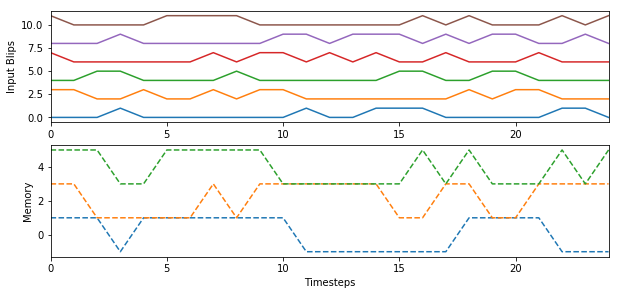

In [ ]:
# JAX handles randomness differently than numpy or matlab. 
# one threads the randomness through to each function. 
#  It's a bit tedious, but very easy to understand and with
# reliable effect.
seed = np.random.randint(0, 1000000) # get randomness from CPU level numpy
print("Seed: %d" % seed)
key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

# Plot a few input/target examples to make sure things look sane.
ntoplot = 20    # how many examples to plot

key, skey = jax.random.split(key, 2)
skeys = jax.random.split(skey, ntoplot) # get ntoplot random keys
inputs, targets, masks = build_inputs_and_targets(input_params, skeys)
# Plot the input to the RNN and the target for the RNN.
input_plot_batch(ntimesteps, inputs, targets)

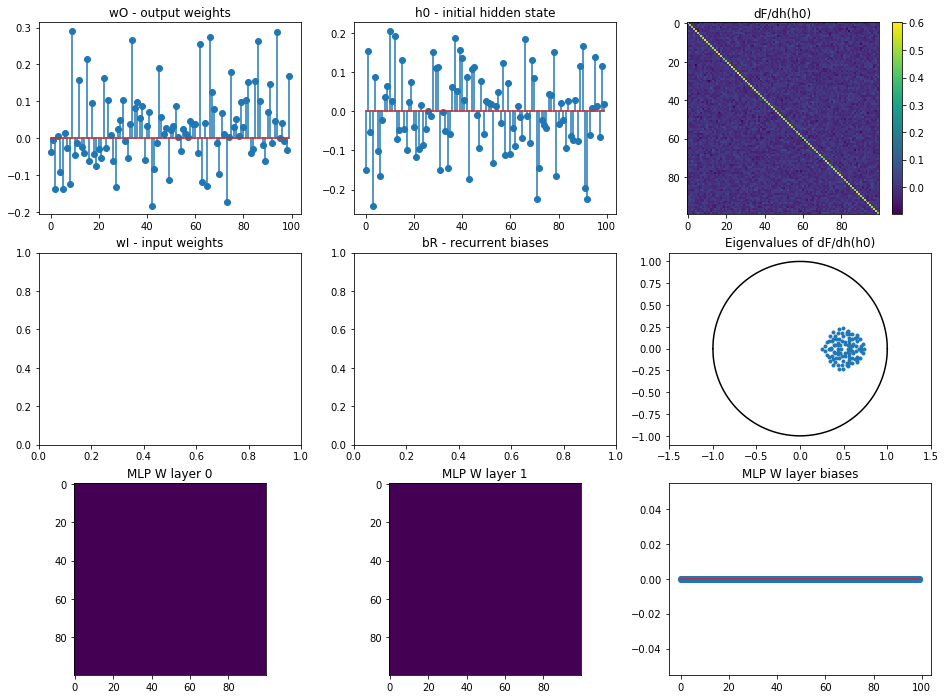

In [ ]:
# Init some parameters for training.
key, subkey = jax.random.split(key, 2)
init_params = jslds_rnn_params(subkey, **hps)
plot_params(init_params, hps)

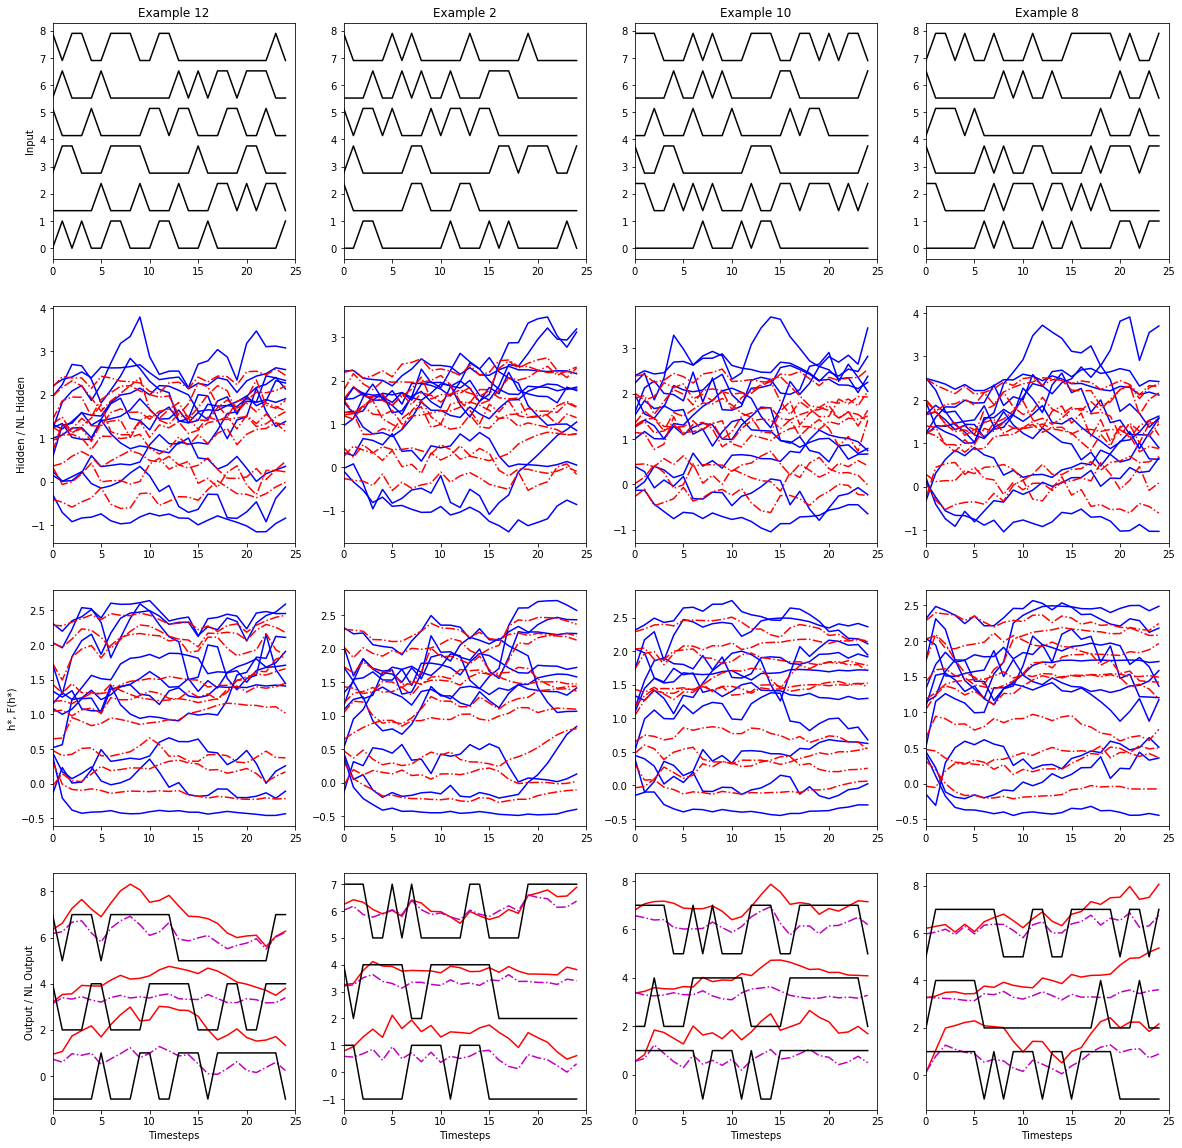

In [ ]:
# Visualize the dynamics of the pretrained network
def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = \
        build_inputs_and_targets(input_params, keys)
    h0s_b = None # Use trained h0
    return inputs_b, targets_b, masks_b, h0s_b

batch_rnn_run = get_batch_rnn_run_fun(hps['rnn']['fun'])
rnn_run = lambda inputs: batch_rnn_run(init_params, inputs)
give_trained_h0 = lambda batch_size : np.array([init_params['rnn']['h0']] * batch_size)

rnn_internals = run_trials(rnn_run, inputs_targets_no_h0s, 1, 16)
plot_examples(ntimesteps, rnn_internals, nexamples=4)

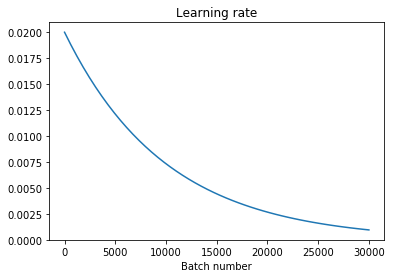

In [ ]:
# Create a decay function for the learning rate
decay_fun = optimizers.exponential_decay(opt_hps['step_size'], 
                                         decay_steps=1, 
                                         decay_rate=opt_hps['decay_factor'])

plt.figure()
plt.subplot(111)
batch_idxs = np.linspace(1, num_batchs)
plt.plot(batch_idxs, [decay_fun(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.title('Learning rate');

### Train the RNN

In [ ]:
# Run the optimization loop, first jit'd call will take a minute.
all_train_losses = []

opt_init, opt_update, opt_get_params = \
    optimizers.adam(decay_fun, opt_hps['adam_b1'], opt_hps['adam_b2'], 
                    opt_hps['adam_eps'])
opt_state = opt_init(init_params)
start_time = time.time()
train_seed = np.random.randint(MAX_SEED_INT)
key = jax.random.PRNGKey(train_seed)
for batch_idx in range(num_batchs):
    key = jax.random.fold_in(key, batch_idx)
    skeys = jax.random.split(key, batch_size)
    inputs, targets, masks = build_inputs_and_targets(input_params, skeys)
    opt_state = update_w_gc_jit(batch_idx, opt_state, opt_update, opt_get_params, inputs,
                                targets, masks, opt_hps['max_grad_norm'], 
                                opt_hps['out_nl_reg'], opt_hps['out_staylor_reg'],
                                opt_hps['taylor_reg'], opt_hps['fp_reg'], 
                                opt_hps['l2_reg'], 
                                hps['rnn']['fun'])
    if batch_idx % print_every == 0:
        params = opt_get_params(opt_state)
        all_train_losses.append(loss_jit(params, inputs, targets, masks,
                                        opt_hps['out_nl_reg'],
                                        opt_hps['out_staylor_reg'],
                                        opt_hps['taylor_reg'], 
                                        opt_hps['fp_reg'], 
                                        opt_hps['l2_reg'], 
                                        hps['rnn']['fun']))
        train_loss = all_train_losses[-1]['total']
        batch_time = time.time() - start_time
        step_size = decay_fun(batch_idx)
        s = "Batch {} in {:0.2f} sec, step size: {:0.5f}, training loss {:0.4f}"
        print(s.format(batch_idx, batch_time, step_size, train_loss))
        start_time = time.time()
        
# List of dicts to dict of lists
all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Batch 0 in 5.56 sec, step size: 0.02000, training loss 16.1585
Batch 500 in 64.99 sec, step size: 0.01902, training loss 0.4370
Batch 1000 in 65.14 sec, step size: 0.01810, training loss 0.1956
Batch 1500 in 65.06 sec, step size: 0.01721, training loss 0.0950
Batch 2000 in 65.03 sec, step size: 0.01637, training loss 0.0685
Batch 2500 in 64.97 sec, step size: 0.01558, training loss 0.0536
Batch 3000 in 65.11 sec, step size: 0.01482, training loss 0.0425
Batch 3500 in 65.04 sec, step size: 0.01409, training loss 0.0351
Batch 4000 in 65.16 sec, step size: 0.01341, training loss 0.0301
Batch 4500 in 65.31 sec, step size: 0.01275, training loss 0.0256
Batch 5000 in 64.97 sec, step size: 0.01213, training loss 0.0221
Batch 5500 in 65.06 sec, step size: 0.01154, training loss 0.0207
Batch 6000 in 65.05 sec, step size: 0.01098, training loss 0.0182
Batch 6500 in 65.11 sec, step size: 0.01044, training loss 0.0167
Batch 7000 in 65.03 sec, step size: 0.00993, training loss 0.0153
Batch 7500 in 

# Testing

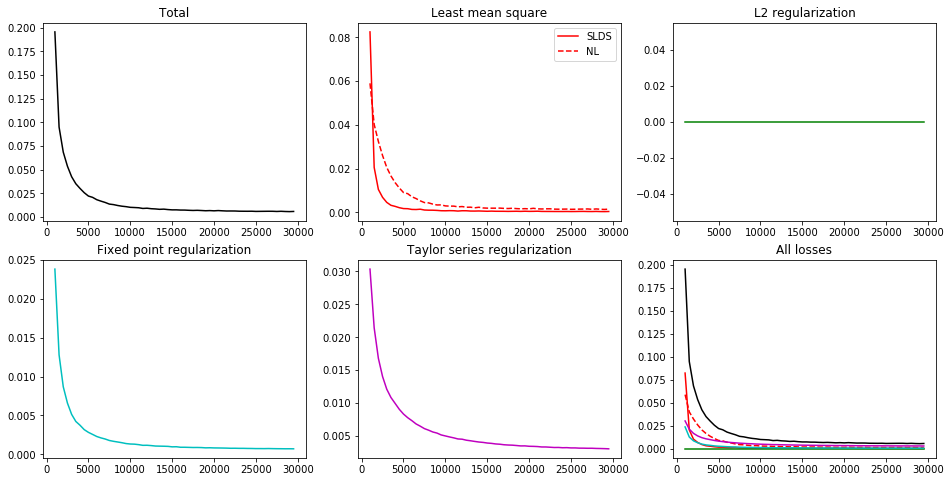

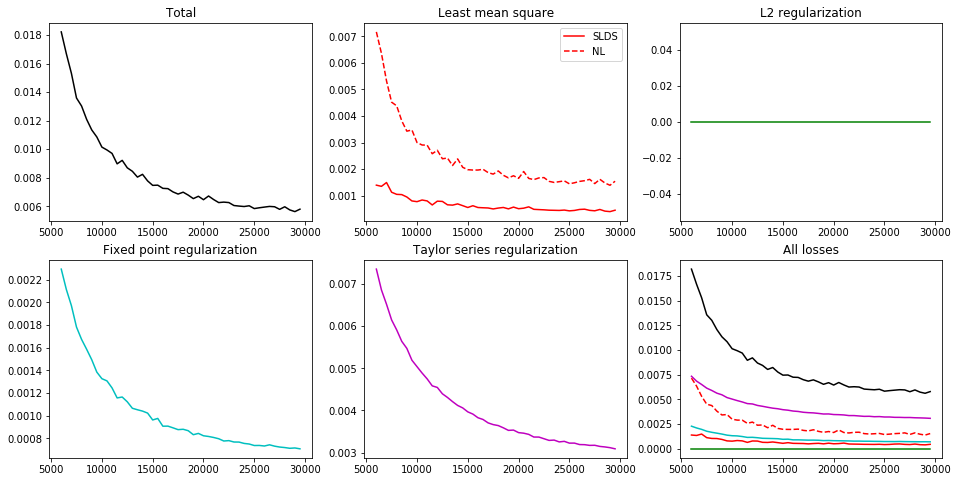

In [ ]:
# Show the loss through training.
x = np.arange(0, num_batchs, print_every)
for xl1,xl2 in [(1000, num_batchs), (6000, num_batchs)]:
    xl1 = int(xl1/print_every)
    xl2 = int(xl2/print_every)

    plt.figure(figsize=(16,8))
    plt.subplot(231)
    plt.plot(x[xl1:xl2], all_train_losses['total'][xl1:xl2], 'k')
    plt.title('Total')

    plt.subplot(232)
    plt.plot(x[xl1:xl2], all_train_losses['lms_jslds'][xl1:xl2], 'r')
    plt.plot(x[xl1:xl2], all_train_losses['lms_nl'][xl1:xl2], 'r--')

    plt.legend(('SLDS', 'NL'))
    plt.title('Least mean square')

    plt.subplot(233)

    plt.plot(x[xl1:xl2], all_train_losses['l2'][xl1:xl2], 'g');
    plt.title('L2 regularization')

    plt.subplot(234)
    plt.plot(x[xl1:xl2], all_train_losses['fixed_point'][xl1:xl2], 'c');
    plt.title('Fixed point regularization')

    plt.subplot(235)
    plt.plot(x[xl1:xl2], all_train_losses['taylor'][xl1:xl2], 'm');
    plt.title('Taylor series regularization')


    plt.subplot(236)
    plt.plot(x[xl1:xl2], all_train_losses['total'][xl1:xl2], 'k')
    plt.plot(x[xl1:xl2], all_train_losses['lms_jslds'][xl1:xl2], 'r')
    plt.plot(x[xl1:xl2], all_train_losses['lms_nl'][xl1:xl2], 'r--')
    plt.plot(x[xl1:xl2], all_train_losses['l2'][xl1:xl2], 'g')
    plt.plot(x[xl1:xl2], all_train_losses['fixed_point'][xl1:xl2], 'c')
    plt.plot(x[xl1:xl2], all_train_losses['taylor'][xl1:xl2], 'm')
    plt.title('All losses');

Loss on a new large batch: 0.001892


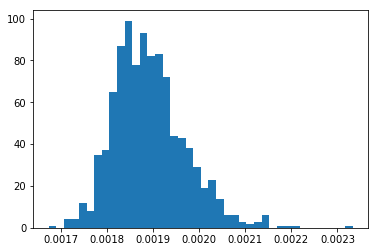

In [38]:
# Take a batch for an evalulation loss, notice the L2 penalty is 0
# for the evaluation.
params = opt_get_params(opt_state)

ntries = 1000
eval_losses = np.zeros(ntries)
for try_idx in range(ntries):
    key, subkey = jax.random.split(key, 2)
    skeys = jax.random.split(subkey, batch_size)
    inputs, targets, masks = build_inputs_and_targets(input_params, skeys)
    eval_loss = loss_jit(params, inputs, targets, masks,
                         opt_hps['out_nl_reg'],
                         opt_hps['out_staylor_reg'],
                         0.0, 0.0, 0.0, 
                         hps['rnn']['fun'])['total']
    eval_losses[try_idx] = eval_loss

eval_loss_mean = np.mean(eval_losses)
eval_loss_str = "{:.6f}".format(eval_loss_mean)
print("Loss on a new large batch: %s" % (eval_loss_str))    
plt.hist(eval_losses, 40);

# Saving

In [39]:
# Define directories, etc.
rnn_type = 'jslds'
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
print(fname_uniquifier)

2020-07-17_11:17:56


In [40]:
# Save parameters
params_fname = ('trained_params_' + rnn_type + '_' + task_type + '_' + \
                eval_loss_str + '_' + fname_uniquifier + '.npz')
params_fname = os.path.join(params_fname)

print("Saving params in %s" % (params_fname))
np.savez(params_fname, params, hps, opt_hps)

Saving params in trained_params_jslds_nbit_memory_0.001892_2020-07-17_11:17:56.npz


In [ ]:
%download_file trained_params_jslds_nbit_memory_0.001892_2020-07-17_11:17:56.npz

In [41]:
# After training, you can load these up, after locating the save file.
if False:
  network_path = 'trained_params_jslds_binary_decision_0.112361_2020-07-14_17:09:50.npz'
  loaded_params = np.load(network_path, allow_pickle=True)
  params = loaded_params['arr_0'].item()
  hps = loaded_params['arr_1'].item()
  opt_hps = loaded_params['arr_2'].item()

### Visualizations of trained system

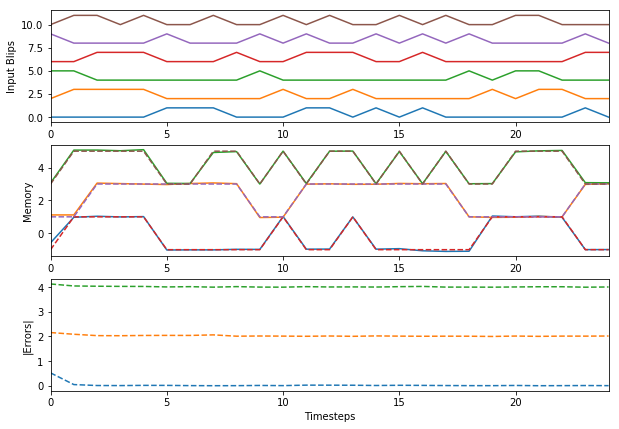

In [42]:
# Visualize how good the trained model is.

rnn_run = lambda inputs: batch_rnn_run(params, inputs)
give_trained_h0 = lambda batch_size : np.array([params['rnn']['h0']] * batch_size)

rnn_internals = run_trials(rnn_run, inputs_targets_no_h0s, 1, batch_size)

input_plot_batch(ntimesteps, rnn_internals['inputs'], 
           rnn_internals['targets'], rnn_internals['nl_outputs'], 
           np.abs(rnn_internals['targets'] - rnn_internals['outputs']))

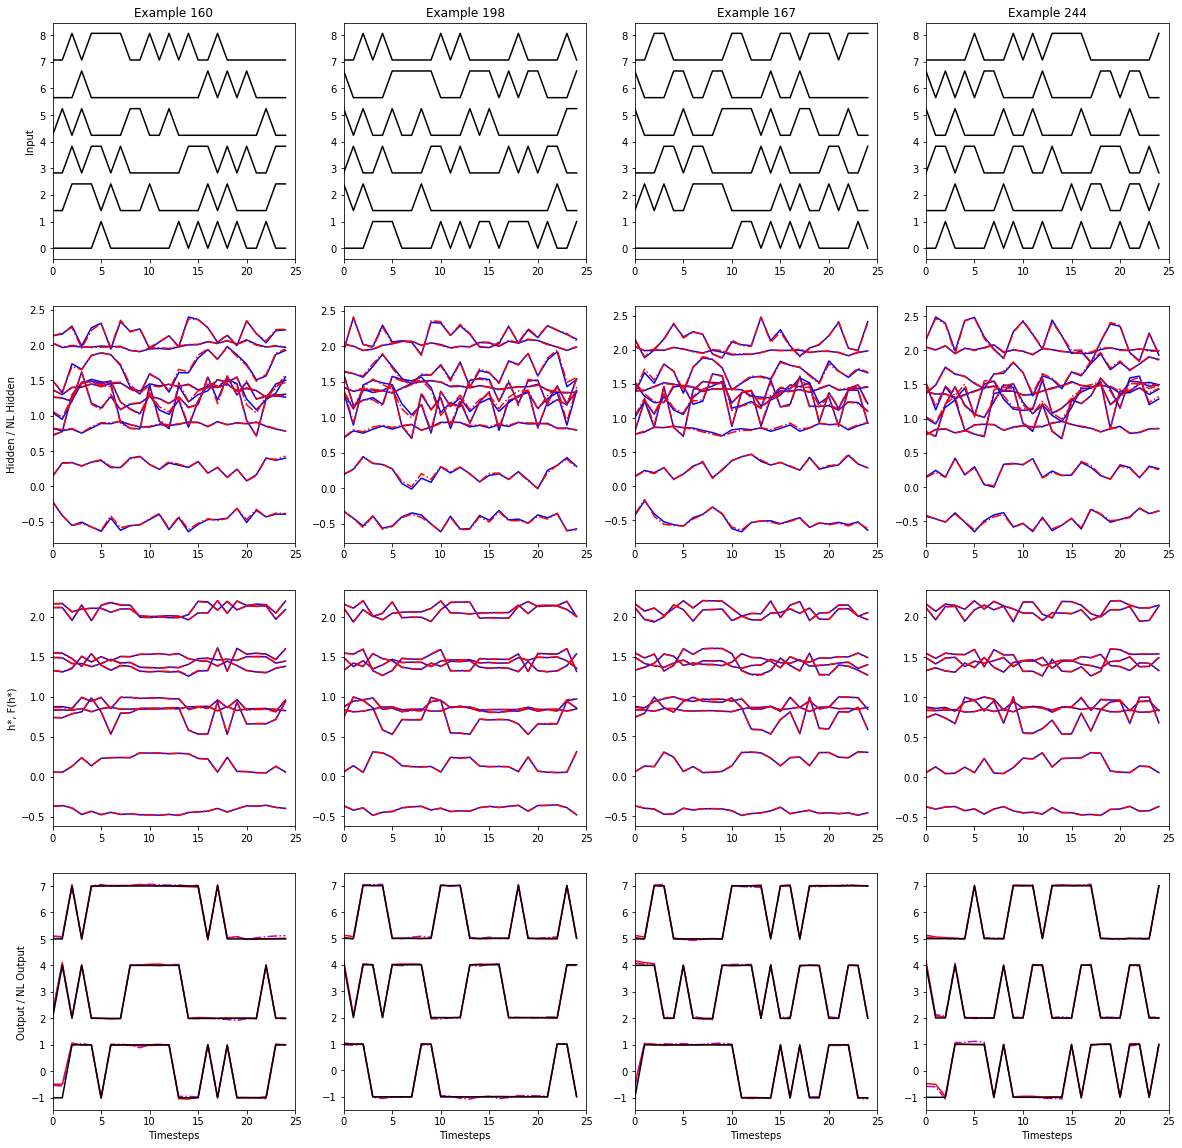

In [43]:
# Visualize the hidden state, as an example.
plot_examples(ntimesteps, rnn_internals, nexamples=4)

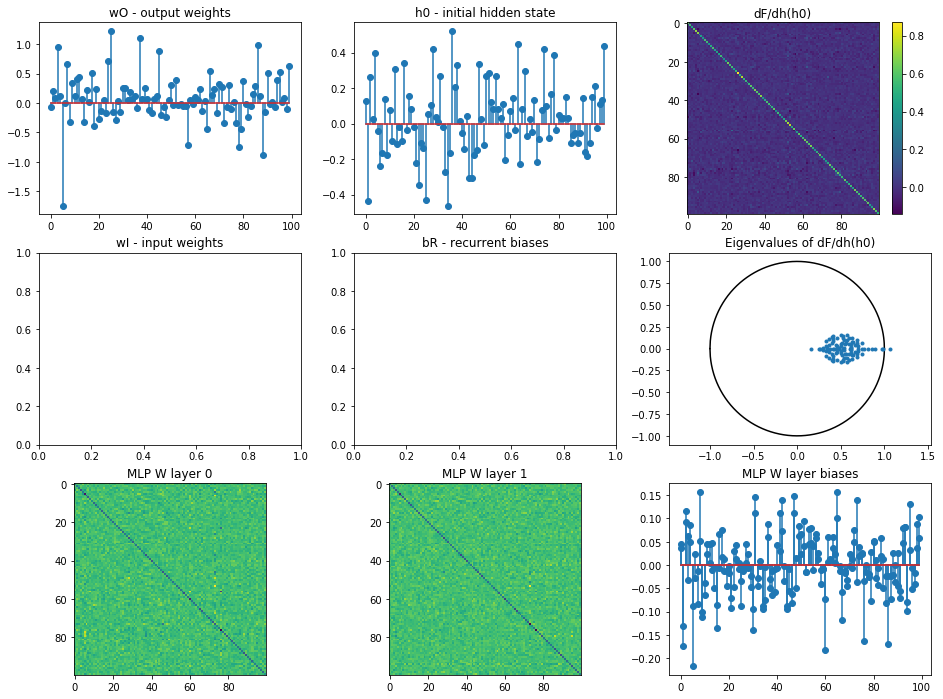

In [44]:
# Take a look at the trained parameters.
plot_params(params, hps)

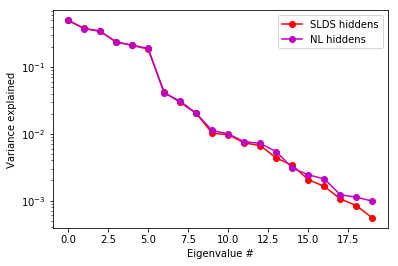

In [45]:
hiddens = np.reshape(rnn_internals['hiddens'], (-1, n))
nl_hiddens = np.reshape(rnn_internals['nl_hiddens'], (-1, n))

pca = PCA(n_components=n).fit(hiddens)
plt.semilogy(pca.explained_variance_[0:20], '-ro')
pca = PCA(n_components=n).fit(nl_hiddens)
plt.semilogy(pca.explained_variance_[0:20], '-mo');
plt.xlabel('Eigenvalue #')
plt.ylabel('Variance explained')
plt.legend(('SLDS hiddens', 'NL hiddens'));

### How good are the dynamics of the JSLDS around the given expansion point at explaining the _nonlinear_ dynamics? 

0.03210744


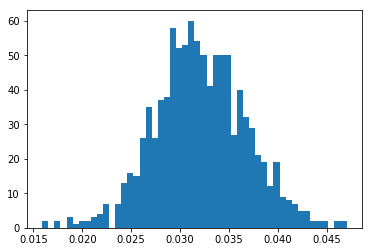

In [53]:
# This is with reset to the nl dynamics after each time point.

# Warning, as implemented, this is slow.  It could be sped up with 
# some vmaps and jits.
inputs_bxtxu = rnn_internals['inputs']
hiddens_bxtxn = rnn_internals['hiddens']
nl_hiddens_bxtxn = rnn_internals['nl_hiddens']
hstars_bxtxn = rnn_internals['h_stars']

x_star = np.zeros_like(inputs_bxtxu[0,0,:])

order = 1
jslds = (lambda h_star, x_star, h_taylor, x: 
             taylor_approx_rnn(rnn_fun, params['rnn'], 
                               h_star, x_star, h_taylor, x, order))

slds_errors = []
nl_h_approxs = []
nl_h = []
for bidx in range(40): 
    for t in range(ntimesteps):
        x = inputs_bxtxu[bidx, t, :]
        h = nl_hiddens_bxtxn[bidx, t, :]
        h_taylor = h # assume two systems start in the same state.
        h_star = mlp(params['mlp'], h_taylor)
        
        h_taylor_tp1 = jslds(h_star, x_star, h_taylor, x)
        h_tp1 = rnn_fun(params['rnn'], h, x)
        nl_h_approxs.append(h_taylor_tp1)
        nl_h.append(h_tp1)
        slds_errors.append(np.linalg.norm(h_tp1 - h_taylor_tp1) / np.linalg.norm(h_tp1))

print(np.mean(slds_errors))
plt.hist(slds_errors, 50);

nl_h_approxs = np.array(nl_h_approxs)
nl_h = np.array(nl_h)

In [54]:
def get_colors_from_readout(params):
  def colors_from_readout(states_dn):
    color_3d = np.dot(params['out']['W'], states_dn.T) + np.expand_dims(params['out']['b'], axis=1)
    color_d3 = color_3d.T
    color_d3 = np.where(color_d3 > 1.0, 1.0, color_d3)
    color_d3 = np.where(color_d3 < -1.0, -1.0, color_d3)
    return (color_d3 + 1.0) / 2.0
  return colors_from_readout

def get_apply_readout(params):
  def apply_readout(states_dn):
    return (np.dot(params['out']['W'], states_dn.T) + np.expand_dims(params['out']['b'], axis=1)).T
  return apply_readout

colors_from_readout = get_colors_from_readout(params)
apply_readout = get_apply_readout(params)

In [55]:
ntoplot = 50

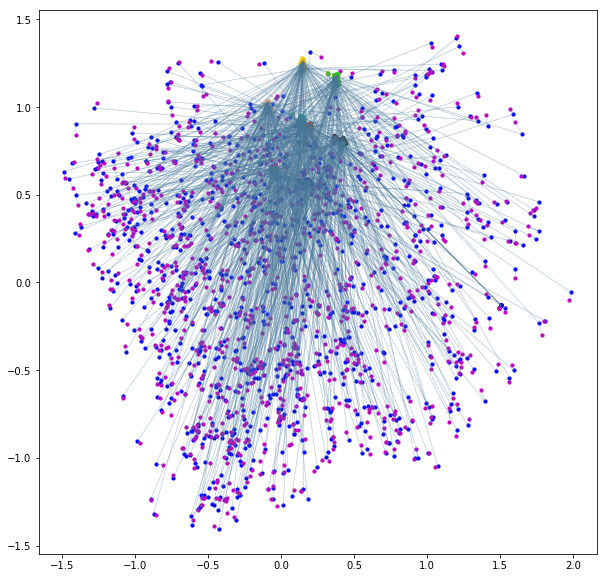

In [58]:
# Show the SLDS pivot points as the JSLDS network computes.
plt.figure(figsize=(10,10))
nl_hiddens = np.reshape(rnn_internals['nl_hiddens'][:ntoplot], (-1, n))
hiddens = np.reshape(rnn_internals['hiddens'][:ntoplot], (-1, n))
hstars = np.reshape(rnn_internals['h_stars'][:ntoplot], (-1, n))

pca = PCA(n_components=2).fit(nl_hiddens)
hstar_pca = pca.transform(hstars)
h_pca = pca.transform(hiddens)
nlh_pca = pca.transform(nl_hiddens)

emax = 1000
plt.scatter(h_pca[0:emax,0], h_pca[0:emax,1], 
            color='b', s=10)
plt.scatter(nlh_pca[0:emax,0], nlh_pca[0:emax,1], 
            color='m', s=10)


for eidx in range(emax):
    plt.arrow(h_pca[eidx,0], h_pca[eidx,1], 
              hstar_pca[eidx,0]-h_pca[eidx,0], 
              hstar_pca[eidx,1]-h_pca[eidx,1], 
              **dict(linestyle='--', ec=[0.5, 0.5, 0.5, 0.1], 
                     head_width=0.0, head_length=0.0))
    plt.arrow(h_pca[eidx,0], h_pca[eidx,1], 
              nlh_pca[eidx,0]-h_pca[eidx,0], 
              nlh_pca[eidx,1]-h_pca[eidx,1], 
              **dict(linestyle='--', ec=[0.5, 0.5, 0.5, 0.1], 
                     head_width=0.0, head_length=0.0))

colors = colors_from_readout(hstars)
plt.scatter(hstar_pca[:emax,0], hstar_pca[:emax,1], s=10, color=colors[:emax,:]);

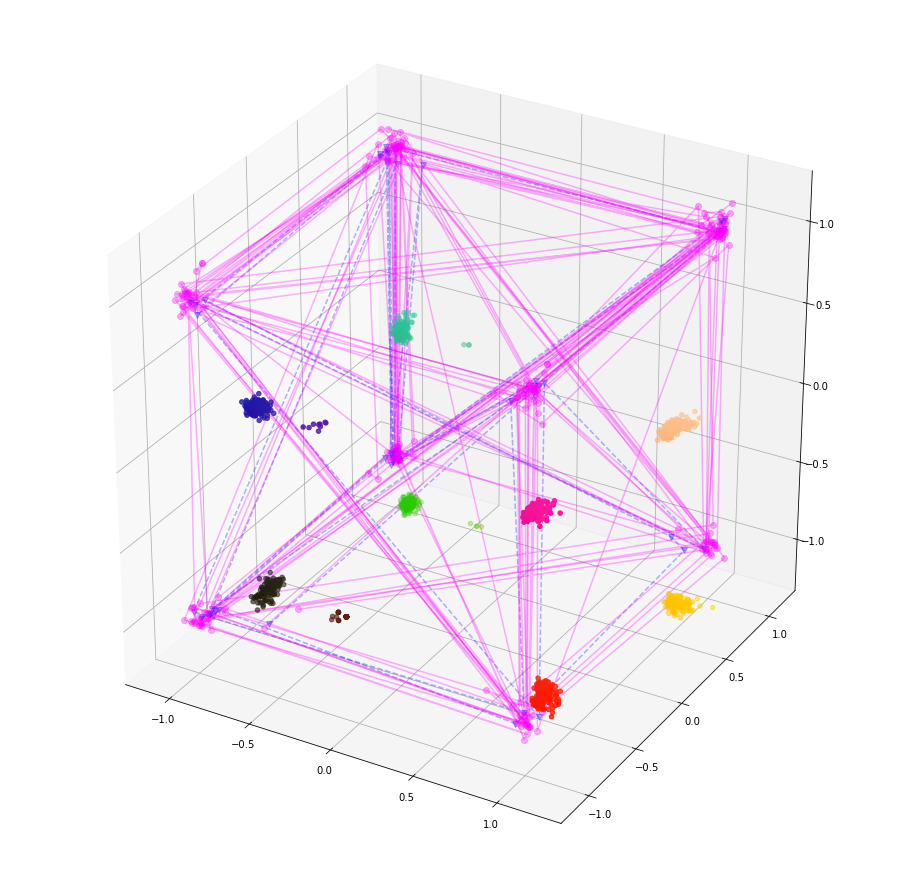

In [59]:
do_pca = False
do_readouts = True

all_nl_hiddens = np.reshape(rnn_internals['nl_hiddens'][:ntoplot], (-1, n))
nl_hiddens = np.reshape(nl_h, (-1, n))
nl_approx_hiddens = np.reshape(nl_h_approxs[:ntoplot], (-1, n))
hstars = np.reshape(rnn_internals['h_stars'][:ntoplot], (-1, n))

if do_pca:
    pca = PCA(n_components=3).fit(all_nl_hiddens)
    nlh_pca = pca.transform(nl_hiddens)
    nlha_pca = pca.transform(nl_approx_hiddens)
    hstar_pca = pca.transform(hstars)
elif do_readouts:
    nlh_pca = apply_readout(nl_hiddens)
    nlha_pca = apply_readout(nl_approx_hiddens)
    hstar_pca = apply_readout(hstars)

color = colors_from_readout(hstars)
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
nexamples = 10
for eidx in range(nexamples):
    start_idx = eidx * ntimesteps
    stop_idx = (eidx + 1) * ntimesteps
    ax.plot3D(nlh_pca[start_idx:stop_idx,0], nlh_pca[start_idx:stop_idx,1], 
              nlh_pca[start_idx:stop_idx,2], '-o', c=[1, 0, 1, 0.3])
    ax.plot3D(nlha_pca[start_idx:stop_idx,0], nlha_pca[start_idx:stop_idx,1], 
              nlha_pca[start_idx:stop_idx,2], '--v', c=[0, 0, 1, 0.3])
                                                      

ax.scatter(hstar_pca[:,0], hstar_pca[:,1], hstar_pca[:,2], color=color);

plt.show();

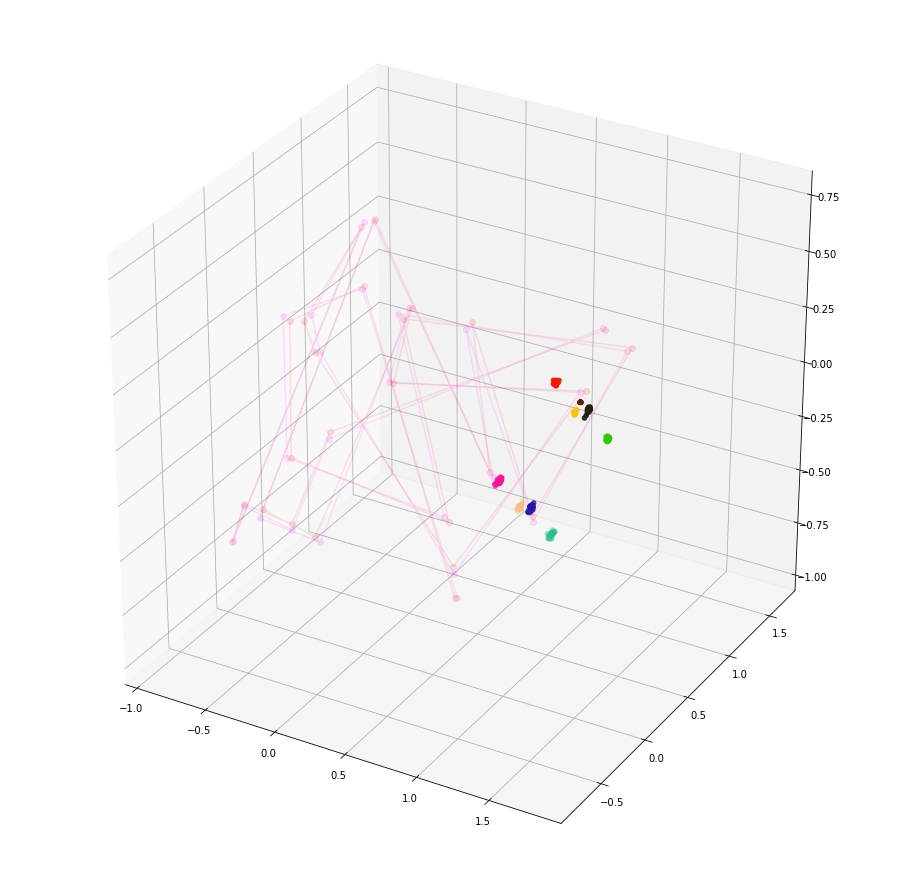

In [65]:
do_pca = True
do_readouts = False

ntoplot = 10
hiddens = np.reshape(rnn_internals['hiddens'][:ntoplot], (-1, n))
nl_hiddens = np.reshape(rnn_internals['nl_hiddens'][:ntoplot], (-1, n))
hstars = np.reshape(rnn_internals['h_stars'][:ntoplot], (-1, n))

if do_pca:
    pca = PCA(n_components=3).fit(hiddens)
    h_pca = pca.transform(hiddens)
    nlh_pca = pca.transform(nl_hiddens)
    hstar_pca = pca.transform(hstars)
elif do_readouts:
    h_pca = apply_readout(hiddens)
    nlh_pca = apply_readout(nl_hiddens)
    hstar_pca = apply_readout(hstars)

emax = h_pca.shape[0]

color = colors_from_readout(hstars)

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

nexamples = 1
for eidx in range(nexamples):
    start_idx = eidx * ntimesteps
    stop_idx = (eidx + 1) * ntimesteps
    ax.plot3D(h_pca[start_idx:stop_idx,0], h_pca[start_idx:stop_idx,1], 
              h_pca[start_idx:stop_idx,2], '-o', c=[1, 0, 0, 0.1])

    ax.plot3D(nlh_pca[start_idx:stop_idx,0], nlh_pca[start_idx:stop_idx,1], 
              nlh_pca[start_idx:stop_idx,2], '-o', c=[1, 0, 1, 0.1])
                                                      
ax.scatter(hstar_pca[:,0], hstar_pca[:,1], hstar_pca[:,2], color=color);
plt.show();


### Find the fixed points of the nonlinear RNN.

In [71]:
# Fixed point optimization hyperparameters
fp_num_batches = 10000         # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = 1.0          # initial learning rate
fp_decay_factor = 0.9995     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5

fp_noise_var = 0.01          # Gaussian noise added to fixed point candidates before optimization.
fp_opt_print_every = 500   # Print training information during optimziation every so often
fp_opt_stop_tol = 0.0
if task_type == 'integration':
  fp_tol = 0.0000001             # Discard fps with squared speed larger than this value.
elif task_type == 'nbit_memory':
  fp_tol = 0.0000005
elif task_type == 'lorenz':
  fp_tol = 0.0000001

fp_unique_tol = 0.0         # tolerance for determination of identical fixed points
fp_outlier_tol = np.inf     # Anypoint whos closest fixed point is greater than tol is an outlier.

fp_opt_hps = {'num_batches' : fp_num_batches, 'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : fp_opt_stop_tol, 
              'fp_tol' : fp_tol, 'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 'opt_print_every' : fp_opt_print_every}

x_star = np.zeros(u)
rnn_fun_h = lambda h : rnn_fun(params['rnn'], h, x_star)

batch_rnn_fun_h = jax.vmap(rnn_fun_h, in_axes=(0,))
fp_loss_fun = get_fp_loss_fun(rnn_fun_h)
total_fp_loss_fun = get_total_fp_loss_fun(rnn_fun_h)

In [72]:
fp_candidates1 = np.reshape(rnn_internals['h_stars'], (-1, n))

total_fp_loss_fun(fp_candidates1)

DeviceArray(7.10601e-06, dtype=float32)

Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-500 in 0.54 sec, Step size: 0.77875, Training loss 0.00003
    Batches 501-1000 in 0.66 sec, Step size: 0.60645, Training loss 0.00001
    Batches 1001-1500 in 0.67 sec, Step size: 0.47228, Training loss 0.00001
    Batches 1501-2000 in 0.65 sec, Step size: 0.36779, Training loss 0.00001
    Batches 2001-2500 in 0.73 sec, Step size: 0.28642, Training loss 0.00001
    Batches 2501-3000 in 0.73 sec, Step size: 0.22305, Training loss 0.00001
    Batches 3001-3500 in 0.75 sec, Step size: 0.17370, Training loss 0.00001
    Batches 3501-4000 in 0.74 sec, Step size: 0.13527, Training loss 0.00001
    Batches 4001-4500 in 0.73 sec, Step size: 0.10534, Training loss 0.00001
    Batches 4501-5000 in 0.75 sec, Step size: 0.08203, Training loss 0.00000
    Batches 5001-5500 in 0.73 sec, Step size: 0.06388, Training loss 0.00000
    Batches 5501-6000 in 0.74 sec, Step size: 0.04975, Training loss 0.00000
    Batc

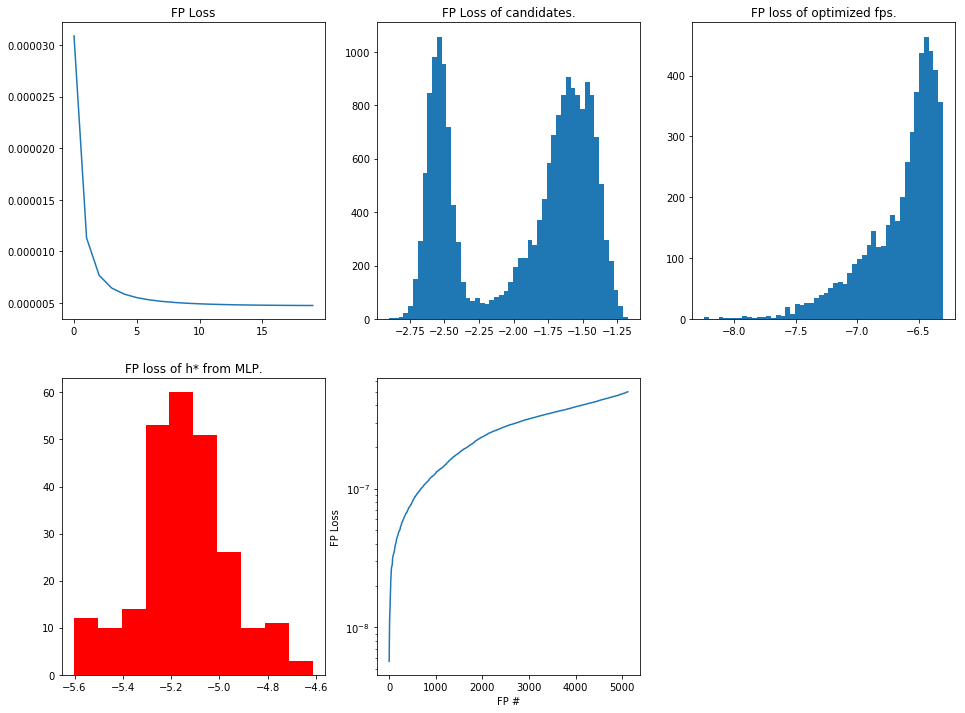

In [73]:
fp_candidates1 = np.reshape(rnn_internals['h_stars'], (-1, n))
fp_candidates2 = np.reshape(rnn_internals['hiddens'], (-1, n))
fp_candidates3 = np.reshape(rnn_internals['nl_hiddens'], (-1, n))
fp_candidates = np.concatenate([fp_candidates1, fp_candidates2, fp_candidates3], 
                               axis=0)

fps, fp_losses, fp_idxs, fp_opt_details = \
    find_fixed_points(rnn_fun_h, fp_candidates, fp_opt_hps, do_print=True)


plt.figure(figsize=(16,12))
plt.subplot(231)
plt.plot(fp_opt_details['fp_losses'])
plt.title('FP Loss')
plt.subplot(232)
plt.hist(np.log10(fp_loss_fun(fp_candidates)), 50)
plt.title('FP Loss of candidates.')
plt.subplot(233)
plt.hist(np.log10(fp_loss_fun(fps)), 50);
plt.title('FP loss of optimized fps.')
plt.subplot(234)
plt.hist(np.log10(fp_loss_fun(hstars)), color='r');
plt.title('FP loss of h* from MLP.');
plt.subplot(235)
plt.semilogy(fp_losses)
plt.xlabel('FP #')
plt.ylabel('FP Loss');

<Figure size 1000x1000 with 0 Axes>

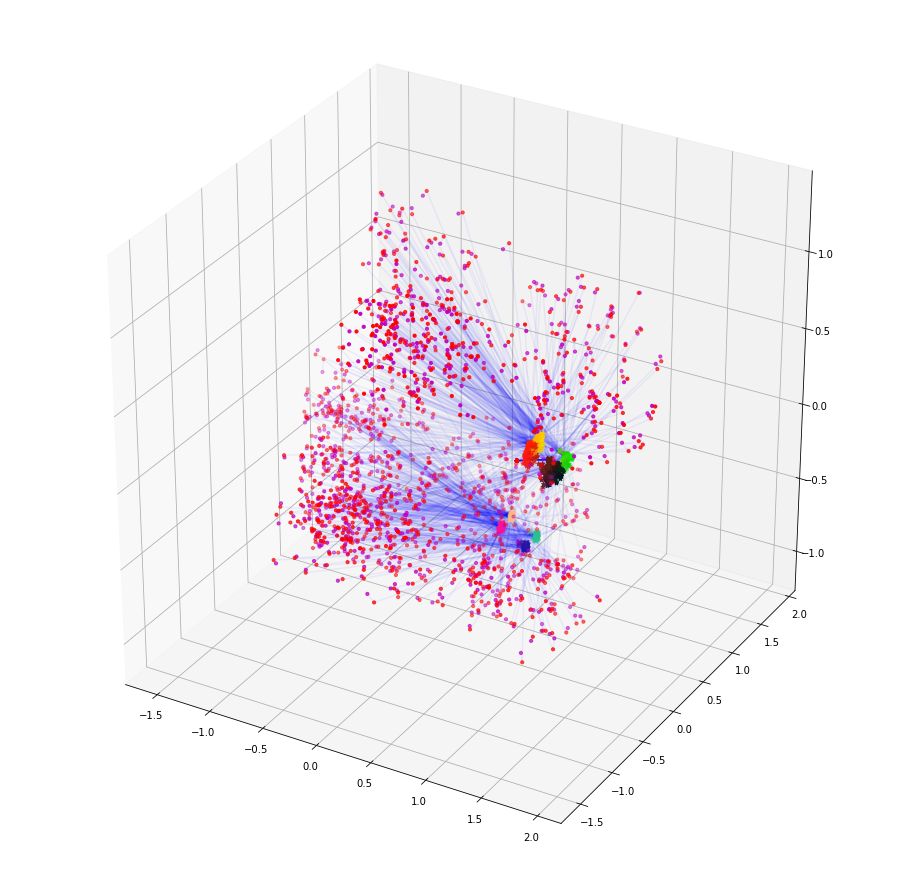

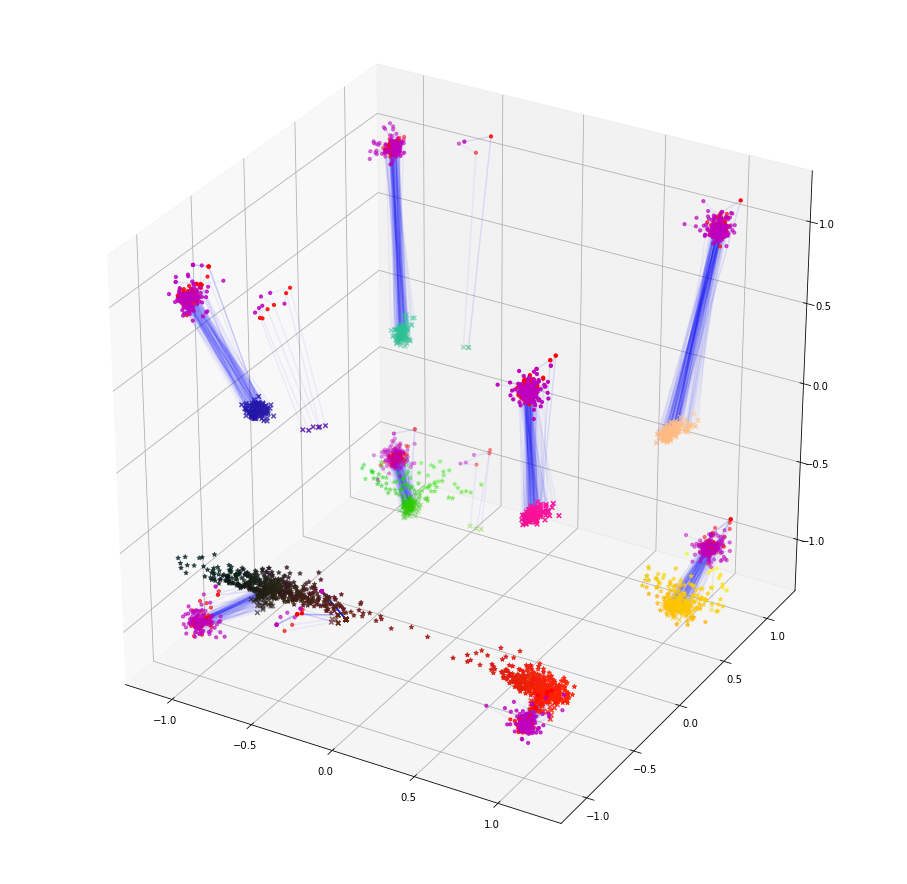

In [75]:
plt.figure(figsize=(10,10))

# Getting the hstars from rnn_internals is wrong here, since they are one time
# step too far ahead.  We want to compare the hidden to the h star it got out 
# of the MLP, which means comparing h_{t-1} to h*_t, but rnn_internals['hiddens']
# is h_t, not h_{t-1}.
ntoplot = 100
h0_1x1xn = np.expand_dims(np.expand_dims(params['rnn']['h0'], axis=0), axis=0)
h0_bx1xn = np.repeat(h0_1x1xn, ntoplot, axis=0)
hiddens_bxtm1xn = rnn_internals['hiddens'][:ntoplot,0:ntimesteps-1,:]
hiddens_tm1_bxtxn = np.concatenate((h0_bx1xn, hiddens_bxtm1xn), axis=1)
hiddens_tm1_btxn = np.reshape(hiddens_tm1_bxtxn, (-1,n))
hiddens = hiddens_tm1_btxn

nl_hiddens_bxtm1xn = rnn_internals['nl_hiddens'][:ntoplot,0:ntimesteps-1,:]
nl_hiddens_tm1_bxtxn = np.concatenate((h0_bx1xn, nl_hiddens_bxtm1xn), axis=1)
nl_hiddens_tm1_bxtxn = np.concatenate((h0_bx1xn, nl_hiddens_bxtm1xn), axis=1)
nl_hiddens_tm1_btxn = np.reshape(nl_hiddens_tm1_bxtxn, (-1,n))
nl_hiddens = nl_hiddens_tm1_btxn

hstars = batch_mlp(params['mlp'], hiddens_tm1_btxn)

for space in ['pca', 'readout']:
    if space == 'pca':
        pca = PCA(n_components=3).fit(hiddens)
        h_pca = pca.transform(hiddens)
        nlh_pca = pca.transform(nl_hiddens)
        hstar_pca = pca.transform(hstars)
        fps_pca = pca.transform(fps)
    elif space == 'readout':
        h_pca = apply_readout(hiddens)
        nlh_pca = apply_readout(nl_hiddens)
        hstar_pca = apply_readout(hstars)
        fps_pca = apply_readout(fps)

    emax = 1000 # h_pca.shape[0]

    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(h_pca[0:emax,0], h_pca[0:emax,1], h_pca[0:emax,2], color='r', s=10)
    ax.scatter(nlh_pca[0:emax,0], nlh_pca[0:emax,1], nlh_pca[0:emax,2], color='m', s=10)
    for eidx in range(emax):
        ax.plot3D([h_pca[eidx,0], nlh_pca[eidx,0]], 
                  [h_pca[eidx,1], nlh_pca[eidx,1]],
                  [h_pca[eidx,2], nlh_pca[eidx,2]], c=[0, 0, 1, 0.05])    


    for eidx in range(emax):
        ax.plot3D([h_pca[eidx,0], hstar_pca[eidx,0]], 
                  [h_pca[eidx,1], hstar_pca[eidx,1]],
                  [h_pca[eidx,2], hstar_pca[eidx,2]], c=[0, 0, 1, 0.05])    

    color = colors_from_readout(hstars)
    ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], s=20, 
               color=color[0:emax], marker='x')

    color = colors_from_readout(fps)
    ax.scatter(fps_pca[0:emax,0], fps_pca[0:emax,1], fps_pca[0:emax,2], s=20, 
               color=color[0:emax,:], marker='*')


    plt.axis('equal');



In [ ]:
do_pca = False
do_readouts = True

hiddens = np.reshape(rnn_internals['hiddens'], (-1, n))
nl_hiddens = np.reshape(rnn_internals['nl_hiddens'], (-1, n))
hstars = np.reshape(rnn_internals['h_stars'], (-1, n))

if do_pca:
    pca = PCA(n_components=3).fit(fps)
    fps_pca = pca.transform(fps)
    hstar_pca = pca.transform(hstars)
elif do_readouts:
    hstar_pca = apply_readout(hstars)
    fps_pca = apply_readout(fps)


fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

color = colors_from_readout(hstars)
emax = h_pca.shape[0]
ax.scatter(hstar_pca[:emax,0], hstar_pca[:emax,1], hstar_pca[:emax,2], '.',
           s=10, c=color[:emax,:]);


emax = fps_pca.shape[0]
ax.scatter(fps_pca[:emax,0], fps_pca[:emax,1], fps_pca[:emax,2], '*',
           s=10, color=[0,0,0, 0.5]);


plt.title('Fixed points of NL system (magenta), vs. expansion points of E() (red)')
plt.show();


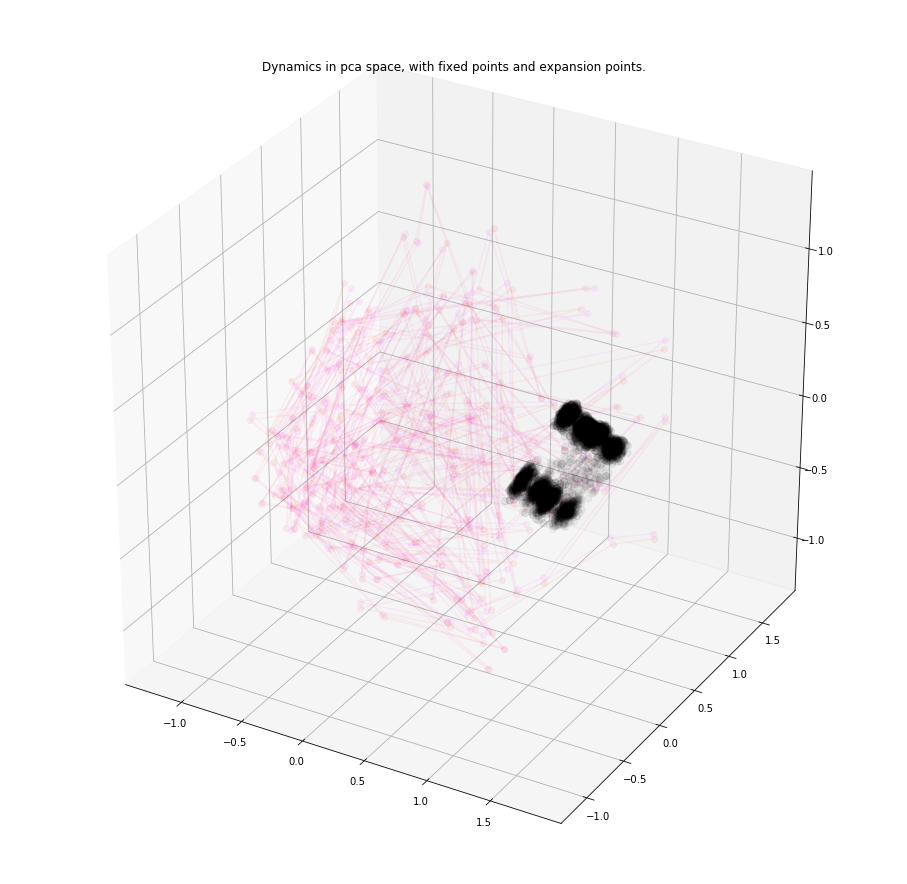

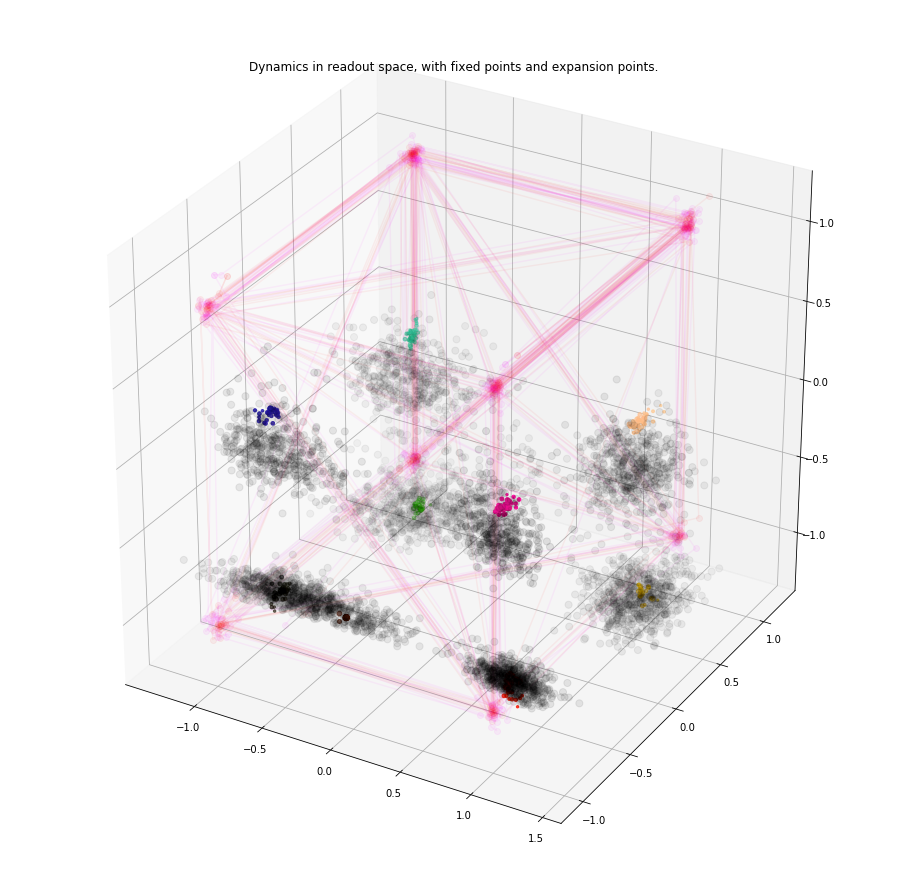

In [77]:
ntoplot = 10
hiddens = np.reshape(rnn_internals['hiddens'][:ntoplot], (-1, n))
nl_hiddens = np.reshape(rnn_internals['nl_hiddens'][:ntoplot], (-1, n))
hstars = np.reshape(rnn_internals['h_stars'][:ntoplot], (-1, n))

for space in ['pca', 'readout']:
    if space == 'pca':
        pca = PCA(n_components=3).fit(hiddens)
        h_pca = pca.transform(hiddens)
        nlh_pca = pca.transform(nl_hiddens)
        hstar_pca = pca.transform(hstars)
        fps_pca = pca.transform(fps)
    elif space == 'readout':
        h_pca = apply_readout(hiddens)
        nlh_pca = apply_readout(nl_hiddens)
        hstar_pca = apply_readout(hstars)
        fps_pca = apply_readout(fps)

    color = colors_from_readout(hstars)
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111, projection='3d')

    nexamples = 50
    for eidx in range(nexamples):
        start_idx = eidx * ntimesteps
        stop_idx = (eidx + 1) * ntimesteps
        ax.plot3D(h_pca[start_idx:stop_idx,0], h_pca[start_idx:stop_idx,1], 
                  h_pca[start_idx:stop_idx,2], '-o', c=[1, 0, 0, 0.05])

        ax.plot3D(nlh_pca[start_idx:stop_idx,0], nlh_pca[start_idx:stop_idx,1], 
                  nlh_pca[start_idx:stop_idx,2], '-o', c=[1, 0, 1, 0.05])


    emax = h_pca.shape[0]
    sizes = 1e-4 / fp_loss_fun(hstars[:emax])
    ax.scatter(hstar_pca[:emax,0], hstar_pca[:emax,1], hstar_pca[:emax,2], 
               color=color[:,0:emax], s=sizes);

    emax = fps.shape[0]
    #sizes = 1e-4/fp_losses[:emax]
    ax.scatter(fps_pca[:emax,0], fps_pca[:emax,1], fps_pca[:emax,2], '*', 
               s=50, color=[0, 0, 0, 0.1]);
    plt.title('Dynamics in %s space, with fixed points and expansion points.' % (space))
    plt.show();

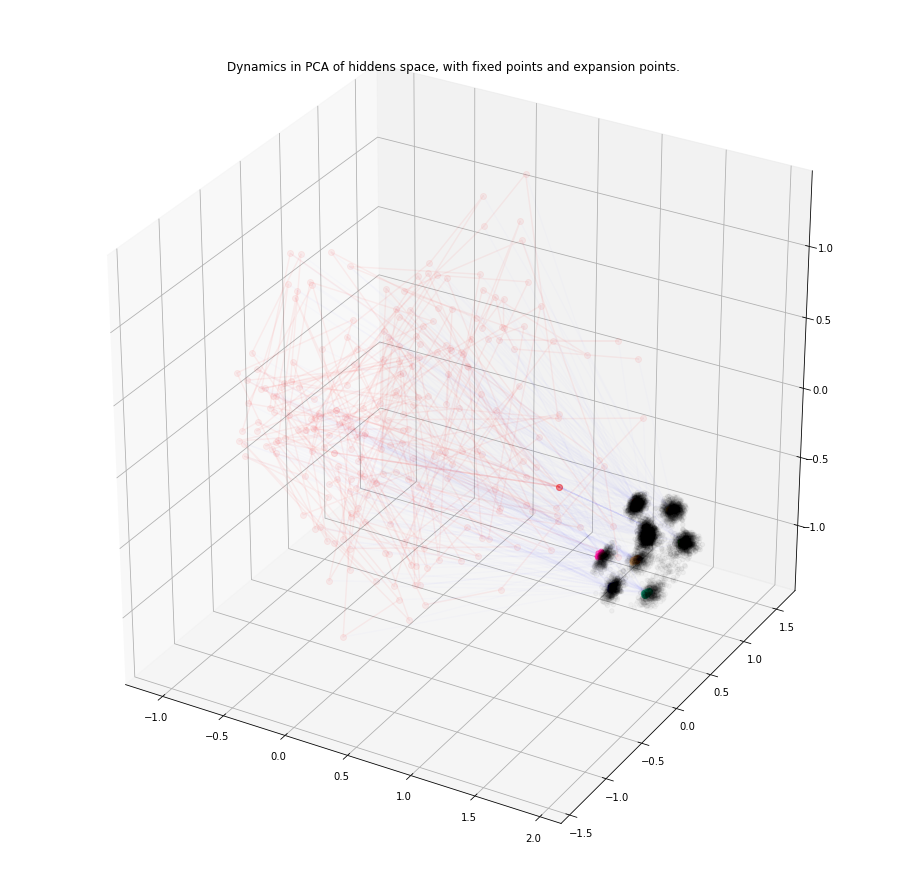

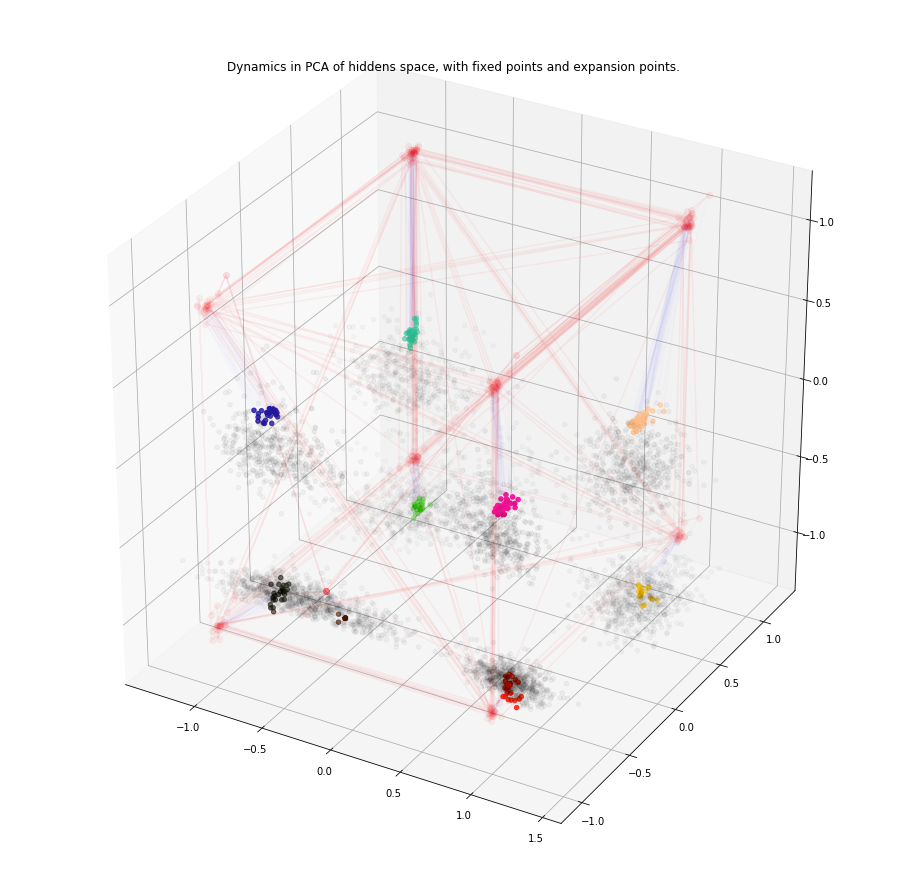

In [78]:
do_pca = True
do_readouts = False


# Getting the hstars from rnn_internals is wrong here, since they are one time
# step too far ahead.  We want to compare the hidden to the h star it got out 
# of the MLP, which means comparing h_{t-1} to h*_t, but rnn_internals['hiddens']
# is h_t, not h_{t-1}.
ntoplot = 10
h0_1x1xn = np.expand_dims(np.expand_dims(params['rnn']['h0'][:], axis=0), axis=0)
h0_bx1xn = np.repeat(h0_1x1xn, ntoplot, axis=0)
hiddens_bxtm1xn = rnn_internals['hiddens'][:ntoplot,0:ntimesteps-1,:]
hiddens_tm1_bxtxn = np.concatenate((h0_bx1xn, hiddens_bxtm1xn), axis=1)
hiddens_tm1_btxn = np.reshape(hiddens_tm1_bxtxn, (-1,n))
hiddens = hiddens_tm1_btxn

nl_hiddens_bxtm1xn = rnn_internals['nl_hiddens'][:ntoplot,0:ntimesteps-1,:]
nl_hiddens_tm1_bxtxn = np.concatenate((h0_bx1xn, nl_hiddens_bxtm1xn), axis=1)
nl_hiddens_tm1_bxtxn = np.concatenate((h0_bx1xn, nl_hiddens_bxtm1xn), axis=1)
nl_hiddens_tm1_btxn = np.reshape(nl_hiddens_tm1_bxtxn, (-1,n))
nl_hiddens = nl_hiddens_tm1_btxn

for space in ['pca', 'readout']:
    if space == 'pca':
        pca = PCA(n_components=3).fit(hiddens)
        h_pca = pca.transform(hiddens)
        nlh_pca = pca.transform(nl_hiddens)
        hstar_pca = pca.transform(hstars)
        fps_pca = pca.transform(fps)
    elif space == 'readout':
        h_pca = apply_readout(hiddens)
        nlh_pca = apply_readout(nl_hiddens)
        hstar_pca = apply_readout(hstars)
        fps_pca = apply_readout(fps)

    color = colors_from_readout(hstars)
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111, projection='3d')

    nexamples = 20
    for eidx in range(nexamples):
        start_idx = eidx * ntimesteps
        stop_idx = (eidx + 1) * ntimesteps
        ax.plot3D(h_pca[start_idx:stop_idx,0], h_pca[start_idx:stop_idx,1], 
                  h_pca[start_idx:stop_idx,2], '-o', c=[1, 0, 0, 0.05])


    emax = h_pca.shape[0]
    for eidx in range(emax):
        ax.plot3D([h_pca[eidx,0], hstar_pca[eidx,0]], 
                   [h_pca[eidx,1], hstar_pca[eidx,1]],
                   [h_pca[eidx,2], hstar_pca[eidx,2]], c=[0, 0, 1, 0.01])    

    emax = h_pca.shape[0]
    ax.scatter(hstar_pca[:emax,0], hstar_pca[:emax,1], hstar_pca[:emax,2], 
               s=20, color=color[0:emax,:]);

    emax = fps_pca.shape[0]
    ax.scatter(fps_pca[:emax,0], fps_pca[:emax,1], fps_pca[:emax,2], '*', 
               s=20, color=[0, 0, 0, 0.05]);

    plt.title('Dynamics in PCA of hiddens space, with fixed points and expansion points.')
    plt.show();

In [80]:
unique_hstar, uidxs = keep_unique_fixed_points(hstars, identical_tol=0.5)
print(total_fp_loss_fun(unique_hstar))

uhstar_jac = compute_jacobians(rnn_fun_h, unique_hstar)
uhstar_eig_decomps = compute_eigenvalue_decomposition(uhstar_jac, 'real')

    Kept 8/250 unique fixed points with uniqueness tolerance 0.500000.
6.8707404e-06


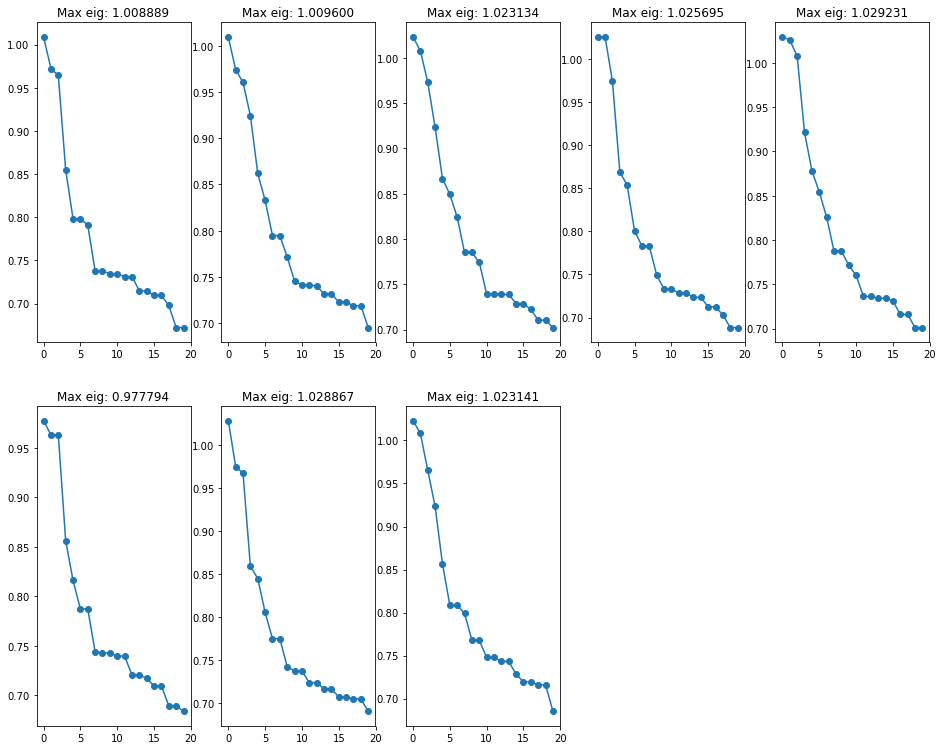

In [81]:
ndecomps = len(unique_hstar) 
ntoplot = ndecomps if ndecomps < 15 else 15
plt.figure(figsize=(16,20))
pidx = 1
xs = np.linspace(-1, 1, 2000)
neigstoplot = 20
for decomp in uhstar_eig_decomps[:ntoplot]:
    plt.subplot(3,5,pidx); pidx += 1
    plt.plot(np.real(decomp['evals'][:neigstoplot]), '-o')
    plt.title('Max eig: %f' % (np.real(decomp['evals'][0])))